In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from utils import resample_ohlcv, calculate_returns
from modelling import calculate_theoretical_futures_price

import warnings
from plot import plot_moving_average

# Suppress specific warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_rows', 200)

In [2]:
col_dict = {'open_price_col': 'open', 'high_price_col': 'high', 'low_price_col': 'low', 'close_price_col': 'close', 'volume_col': 'volume', 
            'time_col':'datetime', 'expiry_col':'expiry_date', 'expiry_type_col':'expiry_type',
            'oi_col':'open_interest','date_col':'date','div_yield_col':'Div Yield %',
            'rfr_col':'MIBOR'}

In [3]:
data = pd.read_csv('Preprocessed_Inputs/Nifty_Futures_01Jan2020_29Jan25.csv',parse_dates=[col_dict['time_col']])

In [10]:
dividend = pd.read_csv('Data/DIV_Data_Jan2020toJan2025.csv',parse_dates=['Date']).rename(columns={'Date':col_dict['date_col']})
dividend.head()

IndexName       date    P/E   P/B  Div Yield %
0  NIFTY 50 2025-02-01  21.29  3.50         1.38
1  NIFTY 50 2025-01-31  21.33  3.51         1.38
2  NIFTY 50 2025-01-30  21.12  3.47         1.37
3  NIFTY 50 2025-01-29  21.06  3.45         1.38
4  NIFTY 50 2025-01-28  20.85  3.42         1.38

In [11]:
rff = pd.read_csv('Data/MIBOR_Jan2020toJan2025.csv',parse_dates=[col_dict['date_col']])
rff.head()

date  MIBOR
0 2020-01-01   5.75
1 2020-01-02   5.75
2 2020-01-03   5.74
3 2020-01-06   5.73
4 2020-01-07   5.73

## Testing theoretical Future price vs Actual

In [6]:
near_month_data = data.loc[data[col_dict['expiry_type_col']] == 'near']
near_month_data = calculate_theoretical_futures_price(near_month_data,
                                                      [col_dict['open_price_col'], col_dict['close_price_col']], 
                                                      col_dict)

mid_month_data = data.loc[data[col_dict['expiry_type_col']] == 'mid']
mid_month_data = calculate_theoretical_futures_price(mid_month_data,
                                                      [col_dict['open_price_col'], col_dict['close_price_col']], 
                                                      col_dict)
far_month_data = data.loc[data[col_dict['expiry_type_col']] == 'far']
far_month_data = calculate_theoretical_futures_price(far_month_data,
                                                      [col_dict['open_price_col'], col_dict['close_price_col']], 
                                                      col_dict)

c:\Users\Preet Lodaya\Quant\modelling.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[[f"{col}_theoretical" for col in price_cols]] = data[price_cols].mul(np.exp((data[col_dict['rfr_col']] - data[col_dict['div_yield_col']])*data['time_to_expiry']),axis=0)
c:\Users\Preet Lodaya\Quant\modelling.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[[f"{col}_theoretical" for col in price_cols]] = data[price_cols].mul(np.exp((data[col_dict['rfr_col']] - data[col_dict['div_yield_col']])*data['time_to_

In [7]:

req_cols = [col_dict['time_col'], col_dict['open_price_col'], col_dict['close_price_col'], col_dict['high_price_col'], col_dict['low_price_col'], 
            col_dict['volume_col'], col_dict['oi_col'], col_dict['expiry_col'],
            f"{col_dict['open_price_col']}_theoretical", f"{col_dict['close_price_col']}_theoretical", 
            f"{col_dict['open_price_col']}_price_diff", f"{col_dict['close_price_col']}_price_diff"]
final_data1 = pd.merge(near_month_data, mid_month_data[req_cols], on=col_dict['time_col'], suffixes=('_near', '_mid'), how = 'left')
final_data = pd.merge(final_data1, far_month_data[req_cols].rename(columns = {c:f"{c}_far" for c in req_cols if c != col_dict['time_col']}), 
                      on=col_dict['time_col'], how = 'left')

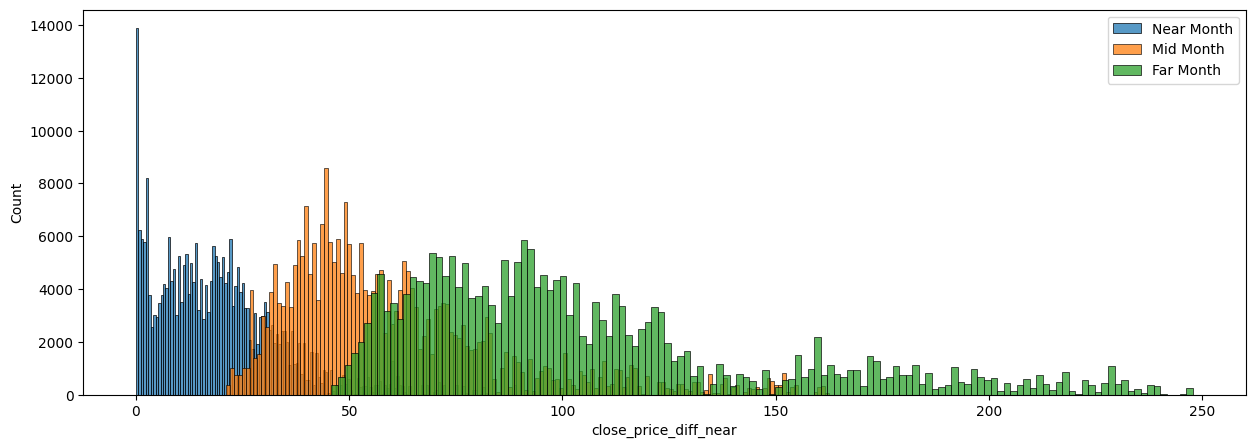

In [8]:
plt.figure(figsize=(15,5))
sns.histplot(final_data[f"{col_dict['close_price_col']}_price_diff_near"],label = 'Near Month')
sns.histplot(final_data[f"{col_dict['close_price_col']}_price_diff_mid"],label = 'Mid Month')
sns.histplot(final_data[f"{col_dict['close_price_col']}_price_diff_far"],label = 'Far Month')
plt.legend()

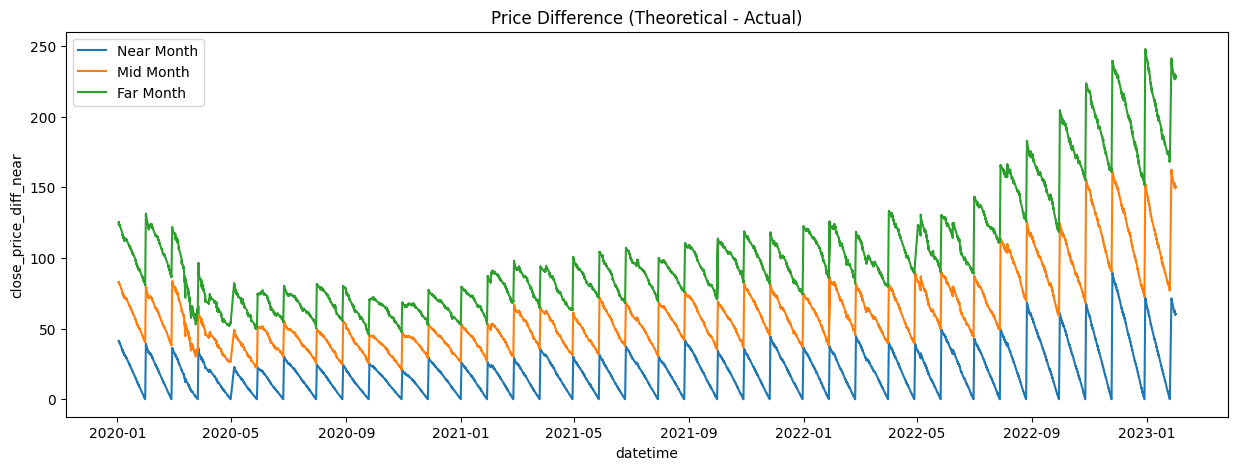

In [9]:
plt.figure(figsize=(15,5))
plt.title('Price Difference (Theoretical - Actual)')
sns.lineplot(data=final_data, x=col_dict['time_col'], y=f"{col_dict['close_price_col']}_price_diff_near", label = 'Near Month')
sns.lineplot(data=final_data,x=col_dict['time_col'], y=f"{col_dict['close_price_col']}_price_diff_mid", label = 'Mid Month')
sns.lineplot(data=final_data, x=col_dict['time_col'], y=f"{col_dict['close_price_col']}_price_diff_far", label = 'Far Month')
plt.legend()

#### OBSERVATION
###### We observe Futures are almost always undervalued from their theoretical prices. 

#### INFERENCE
###### The market either has different expectations of risk free rate and/or the dividend yield from our assumptions

#### Takeaway
###### The spread seems to be monotonically decreasing. We can try to trade this spread.
###### A strategy based on this would 
######  1. In most cases short the index (assuming an instrument like that exists) in equity market and long the future
######  2. Cant hold a short position for more than a day
######  3. To minimize transaction costs, take one position at day start and close at end
###### Ideally such a naive strategy should not work and our returns - transaction costs should not exceed the risk free rates

In [8]:
data_1day = pd.read_csv('Preprocessed_Inputs/Nifty_Futures_01Jan2020_29Jan25_1D.csv',parse_dates=['datetime','expiry_date','date'])
data_1day.shape

(3965, 35)

In [9]:
data_1day.columns

Index(['datetime', 'open', 'high', 'low', 'close', 'volume', 'open_interest',
       'expiry_date', 'date', 'returns', 'log_returns', 'overnight_returns',
       'overnight_log_returns', 'intraday_returns', 'intraday_log_returns',
       'expiry_type', 'MIBOR', 'prev_MIBOR', 'IndexName', 'P/E', 'P/B',
       'Div Yield %', 'datetime_equity', 'open_equity', 'high_equity',
       'low_equity', 'close_equity', 'volume_equity', 'returns_equity',
       'log_returns_equity', 'overnight_returns_equity',
       'overnight_log_returns_equity', 'intraday_returns_equity',
       'intraday_log_returns_equity', 'time_to_expiry'],
      dtype='object')

In [10]:
np.log(0.95)

np.float64(-0.05129329438755058)

In [11]:
data_1day.groupby(col_dict['expiry_col'])['log_returns_equity'].cumsum()

0            NaN
1            NaN
2            NaN
3       0.007621
4       0.007621
          ...   
3960   -0.011291
3961   -0.009859
3962   -0.001197
3963   -0.002628
3964    0.019293
Name: log_returns_equity, Length: 3965, dtype: float64

In [12]:
def margin_call_counter(group, threshold=np.log(0.95)):
    cumsum = 0
    margin_call_count = 0
    margin_call_counts = []
    for ret in group['log_returns']:
        cumsum += ret
        if cumsum <= threshold:
            margin_call_count += 1
            cumsum = 0  # Reset cumsum after margin call
        margin_call_counts.append(margin_call_count)
        margin_call_count = 0
    group['margin_call_count'] = margin_call_counts
    return group
data_mcalls = data_1day.groupby(col_dict['expiry_col'],as_index=False).apply(margin_call_counter)

C:\Users\Preet Lodaya\AppData\Local\Temp\ipykernel_8420\3589969358.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_mcalls = data_1day.groupby(col_dict['expiry_col'],as_index=False).apply(margin_call_counter)


In [20]:
data_mcalls.reset_index(inplace=True, drop=True)

In [27]:
data_mcalls.groupby(col_dict['expiry_col'])['margin_call_count'].max().value_counts()

margin_call_count
0    46
1    17
Name: count, dtype: int64

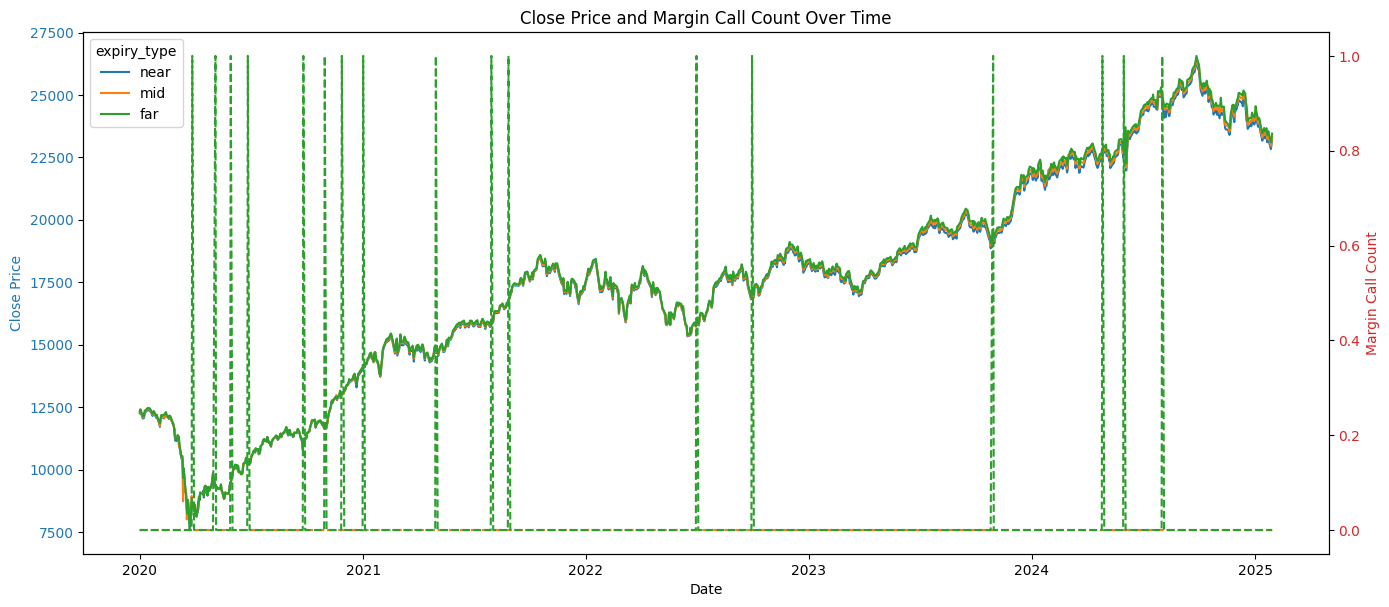

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot close price with hue for expiry_type
sns.lineplot(
    data=data_mcalls,
    x=col_dict['date_col'],
    y=col_dict['close_price_col'],
    hue=col_dict['expiry_type_col'],
    ax=ax1,
    legend=True
)
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot margin_call_count on secondary axis with hue for expiry_type
ax2 = ax1.twinx()
sns.lineplot(
    data=data_mcalls,
    x=col_dict['date_col'],
    y='margin_call_count',
    hue=col_dict['expiry_type_col'],
    ax=ax2,
    legend=False,
    linestyle='--'
)
ax2.set_ylabel('Margin Call Count', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Close Price and Margin Call Count Over Time')
plt.show()

In [13]:
near_month_data = data_1day.loc[data_1day[col_dict['expiry_type_col']] == 'near']
near_month_data = calculate_theoretical_futures_price(near_month_data,
                                                      [col_dict['open_price_col'], col_dict['close_price_col']], 
                                                      col_dict)

mid_month_data = data_1day.loc[data_1day[col_dict['expiry_type_col']] == 'mid']
mid_month_data = calculate_theoretical_futures_price(mid_month_data,
                                                      [col_dict['open_price_col'], col_dict['close_price_col']], 
                                                      col_dict)
far_month_data = data_1day.loc[data_1day[col_dict['expiry_type_col']] == 'far']
far_month_data = calculate_theoretical_futures_price(far_month_data,
                                                      [col_dict['open_price_col'], col_dict['close_price_col']], 
                                                      col_dict)

c:\Users\Preet Lodaya\Quant\modelling.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[[f"{col}_theoretical" for col in price_cols]] = data[price_cols].mul(np.exp((data[col_dict['rfr_col']] - data[col_dict['div_yield_col']])*data['time_to_expiry']),axis=0)
c:\Users\Preet Lodaya\Quant\modelling.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[[f"{col}_theoretical" for col in price_cols]] = data[price_cols].mul(np.exp((data[col_dict['rfr_col']] - data[col_dict['div_yield_col']])*data['time_to_

In [14]:
near_month_data.columns

Index(['datetime', 'open', 'high', 'low', 'close', 'volume', 'open_interest',
       'expiry_date', 'date', 'returns', 'log_returns', 'overnight_returns',
       'overnight_log_returns', 'intraday_returns', 'intraday_log_returns',
       'expiry_type', 'MIBOR', 'prev_MIBOR', 'IndexName', 'P/E', 'P/B',
       'Div Yield %', 'datetime_equity', 'open_equity', 'high_equity',
       'low_equity', 'close_equity', 'volume_equity', 'returns_equity',
       'log_returns_equity', 'overnight_returns_equity',
       'overnight_log_returns_equity', 'intraday_returns_equity',
       'intraday_log_returns_equity', 'time_to_expiry', 'open_theoretical',
       'close_theoretical', 'open_price_diff', 'close_price_diff'],
      dtype='object')

In [15]:

req_cols = [col_dict['date_col'], col_dict['open_price_col'], col_dict['close_price_col'], col_dict['high_price_col'], col_dict['low_price_col'], 
            col_dict['volume_col'], col_dict['oi_col'], col_dict['expiry_col'],
            f"{col_dict['open_price_col']}_theoretical", f"{col_dict['close_price_col']}_theoretical", 
            f"{col_dict['open_price_col']}_price_diff", f"{col_dict['close_price_col']}_price_diff"]
final_data1 = pd.merge(near_month_data, mid_month_data[req_cols], on=col_dict['date_col'], suffixes=('_near', '_mid'), how = 'left')
final_data_1d = pd.merge(final_data1, far_month_data[req_cols].rename(columns = {c:f"{c}_far" for c in req_cols if c != col_dict['date_col']}), 
                      on=col_dict['date_col'], how = 'left')

In [16]:
final_data_1d.sort_values(col_dict['date_col'],inplace=True)
final_data_1d.reset_index(drop=True,inplace=True)
final_data_1d['returns_near'] = np.log(final_data_1d[f"{col_dict['close_price_col']}_near"]/final_data_1d[f"{col_dict['close_price_col']}_near"].shift(1))
final_data_1d['returns_mid'] = np.log(final_data_1d[f"{col_dict['close_price_col']}_mid"]/final_data_1d[f"{col_dict['close_price_col']}_mid"].shift(1))
final_data_1d['returns_far'] = np.log(final_data_1d[f"{col_dict['close_price_col']}_far"]/final_data_1d[f"{col_dict['close_price_col']}_far"].shift(1))
final_data_1d['returns_equity'] = np.log(final_data_1d[f"{col_dict['close_price_col']}_equity"]/final_data_1d[f"{col_dict['close_price_col']}_equity"].shift(1))
final_data_1d['days_to_expiry'] = (pd.to_datetime(final_data_1d['expiry_date_near']) - pd.to_datetime(final_data_1d[col_dict['date_col']])).dt.days
final_data_1d['hour'] = final_data_1d[col_dict['time_col']].dt.hour
final_data_1d['days_to_expiry_buckets'] = pd.cut(final_data_1d['days_to_expiry'], bins = [0,3,6,9,12,15,18,21,24,27,30,33,36], right = False)

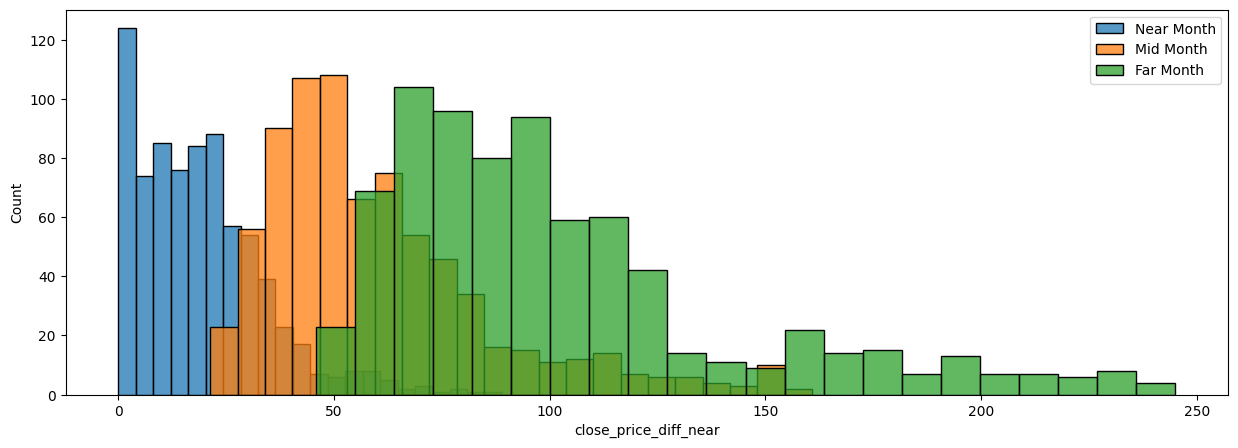

In [99]:
plt.figure(figsize=(15,5))
sns.histplot(final_data[f"{col_dict['close_price_col']}_price_diff_near"],label = 'Near Month')
sns.histplot(final_data[f"{col_dict['close_price_col']}_price_diff_mid"],label = 'Mid Month')
sns.histplot(final_data[f"{col_dict['close_price_col']}_price_diff_far"],label = 'Far Month')
plt.legend()

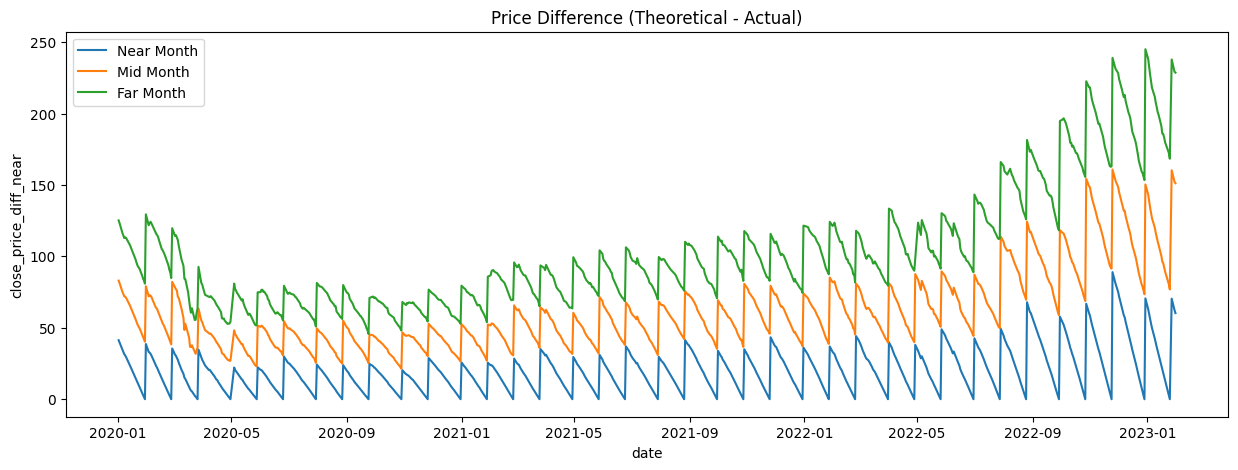

In [65]:
plt.figure(figsize=(15,5))
plt.title('Price Difference (Theoretical - Actual)')
sns.lineplot(data=final_data, x=col_dict['date_col'], y=f"{col_dict['close_price_col']}_price_diff_near", label = 'Near Month')
sns.lineplot(data=final_data,x=col_dict['date_col'], y=f"{col_dict['close_price_col']}_price_diff_mid", label = 'Mid Month')
sns.lineplot(data=final_data, x=col_dict['date_col'], y=f"{col_dict['close_price_col']}_price_diff_far", label = 'Far Month')
plt.legend()

In [ ]:
data_1day.sort_values(col_dict['date_col'], inplace=True)
data_1day.reset_index(drop=True, inplace=True)
spot_market_gain = data_1day.groupby(col_dict['expiry_col']).apply(lambda g: (g[f"{col_dict['open_price_col']}_equity"] - g[f"{col_dict['close_price_col']}_equity"]).sum())
futures_market_gain = data_1day.groupby(col_dict['expiry_col']).apply(lambda g: g.loc[g.index[-1], col_dict['close_price_col']] - g.loc[g.index[0],col_dict['open_price_col']])
(futures_market_gain + spot_market_gain).sum()

C:\Users\Preet Lodaya\AppData\Local\Temp\ipykernel_25036\1100010421.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spot_market_gain = data_1day.groupby(col_dict['expiry_col']).apply(lambda g: (g[f"{col_dict['open_price_col']}_equity"] - g[f"{col_dict['close_price_col']}_equity"]).sum())
C:\Users\Preet Lodaya\AppData\Local\Temp\ipykernel_25036\1100010421.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

np.float64(57661.60080000009)

In [44]:
data_1day[f"prev_{col_dict['close_price_col']}"] = data_1day.groupby(col_dict['expiry_col'])[col_dict['close_price_col']].shift(1)
data_1day['Futures_long_gains'] = data_1day[col_dict['close_price_col']] - data_1day[f"prev_{col_dict['close_price_col']}"]
data_1day.loc[data_1day[f"prev_{col_dict['close_price_col']}"].isna(),'Futures_long_gains'] = data_1day[col_dict['close_price_col']] - data_1day[col_dict['open_price_col']]
data_1day['Spot_short_gains'] = data_1day[f"{col_dict['open_price_col']}_equity"] - data_1day[f"{col_dict['close_price_col']}_equity"]
data_1day['Strategy_gains'] = data_1day['Spot_short_gains'] + data_1day['Futures_long_gains']
data_1day['Daily_capital'] = data_1day['high_equity']*0.2 + data_1day[col_dict['high_price_col']]*0.11

In [178]:
(data_1day.groupby(col_dict['date_col']).apply(lambda g : g['Strategy_gains'].sum()/g['Daily_capital'].sum()).sum())

C:\Users\Preet Lodaya\AppData\Local\Temp\ipykernel_25036\1378165235.py:1: RuntimeWarning: invalid value encountered in scalar divide
  (data_1day.groupby(col_dict['date_col']).apply(lambda g : g['Strategy_gains'].sum()/g['Daily_capital'].sum()).sum())
C:\Users\Preet Lodaya\AppData\Local\Temp\ipykernel_25036\1378165235.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (data_1day.groupby(col_dict['date_col']).apply(lambda g : g['Strategy_gains'].sum()/g['Daily_capital'].sum()).sum())


np.float64(3.6191959008264596)

In [158]:
data_1day.groupby([col_dict['expiry_col'], col_dict['date_col']])['close_equity'].nunique().value_counts()

close_equity
1    3741
0      41
Name: count, dtype: int64

In [132]:
(data_1day[f"{col_dict['open_price_col']}_equity"] - data_1day[f"{col_dict['close_price_col']}_equity"]).sum()

np.float64(37945.050000000076)

In [166]:
data_1day.groupby(col_dict['expiry_type_col'])[col_dict['high_price_col']].mean()*0.12

expiry_type
far     2122.438613
mid     2116.847330
near    2106.970876
Name: high, dtype: float64

In [147]:
3*((data_1day['close']*0.2).mean() + (data_1day['open_equity']*0.2).mean())

np.float64(20991.716139583285)

In [155]:
(data_1day['high_equity']*0.2).mean()*3

np.float64(10518.053549679487)

In [144]:
57661.60080000009/(240*5+23)

47.14767031888805

In [156]:
47/22000

0.0021363636363636363

In [149]:
0.2*240

48.0

In [117]:
(futures_market_gain + spot_market_gain)

expiry_date
2020-01-30     -66.5458
2020-02-27    -553.0438
2020-03-26   -3637.0503
2020-04-30   -1550.5015
2020-05-28   -2314.0513
2020-06-25     506.6529
2020-07-30    1206.4542
2020-08-27     807.7072
2020-09-24     400.8038
2020-10-29     534.6006
2020-11-26    1087.2540
2020-12-31    1544.1026
2021-01-28     551.0458
2021-02-25     929.6006
2021-03-25     518.8974
2021-04-29     260.4990
2021-05-27     -31.7550
2021-06-24    -428.5508
2021-07-29     -56.8506
2021-08-26     300.1992
2021-09-30     392.3964
2021-10-28     646.1992
2021-11-25     260.5568
2021-12-30     591.8476
2022-01-27    -851.6056
2022-02-24    -566.5588
2022-03-31   -1761.7540
2022-04-28    -698.9500
2022-05-26    -832.8000
2022-06-30   -1054.9000
2022-07-28     355.8500
2022-08-25     592.9000
2022-09-29     -28.3500
2022-10-27     361.2500
2022-11-24     193.9500
2022-12-29    1203.4500
2023-01-25     512.1000
2023-02-23    -128.4500
2023-03-29     -62.1000
2023-04-27     202.5500
2023-05-25     303.5500
2023

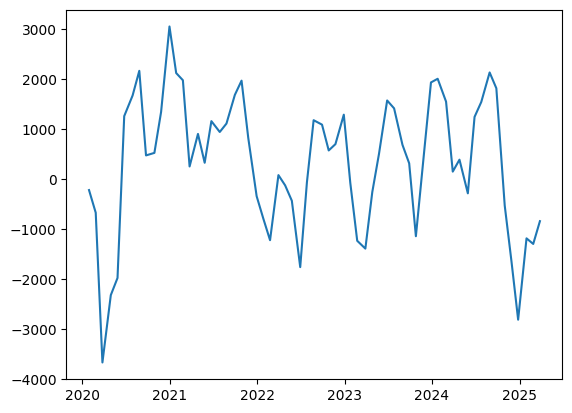

In [140]:
plt.plot(futures_market_gain)

In [20]:
final_data['returns_near'] = final_data.groupby(col_dict['date_col']).apply(lambda g : np.log(g[f"{col_dict['close_price_col']}_near"]/g[f"{col_dict['close_price_col']}_near"].shift(1))).reset_index(level=0, drop=True)
final_data['returns_mid'] = final_data.groupby(col_dict['date_col']).apply(lambda g : np.log(g[f"{col_dict['close_price_col']}_mid"]/g[f"{col_dict['close_price_col']}_mid"].shift(1))).reset_index(level=0, drop=True)
final_data['returns_far'] = final_data.groupby(col_dict['date_col']).apply(lambda g : np.log(g[f"{col_dict['close_price_col']}_far"]/g[f"{col_dict['close_price_col']}_far"].shift(1))).reset_index(level=0, drop=True)
final_data['returns_equity'] = final_data.groupby(col_dict['date_col']).apply(lambda g : np.log(g[f"{col_dict['close_price_col']}_equity"]/g[f"{col_dict['close_price_col']}_equity"].shift(1))).reset_index(level=0, drop=True)
final_data['days_to_expiry'] = (pd.to_datetime(final_data['expiry_date_near']) - pd.to_datetime(final_data[col_dict['date_col']])).dt.days
final_data['hour'] = final_data[col_dict['time_col']].dt.hour
final_data['days_to_expiry_buckets'] = pd.cut(final_data['days_to_expiry'], bins = [0,3,6,9,12,15,18,21,24,27,30,33,36], right = False)

C:\Users\Preet Lodaya\AppData\Local\Temp\ipykernel_8420\1284851288.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_data['returns_near'] = final_data.groupby(col_dict['date_col']).apply(lambda g : np.log(g[f"{col_dict['close_price_col']}_near"]/g[f"{col_dict['close_price_col']}_near"].shift(1))).reset_index(level=0, drop=True)
C:\Users\Preet Lodaya\AppData\Local\Temp\ipykernel_8420\1284851288.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping co

2.36082084780921e-05 0.11288711288711288


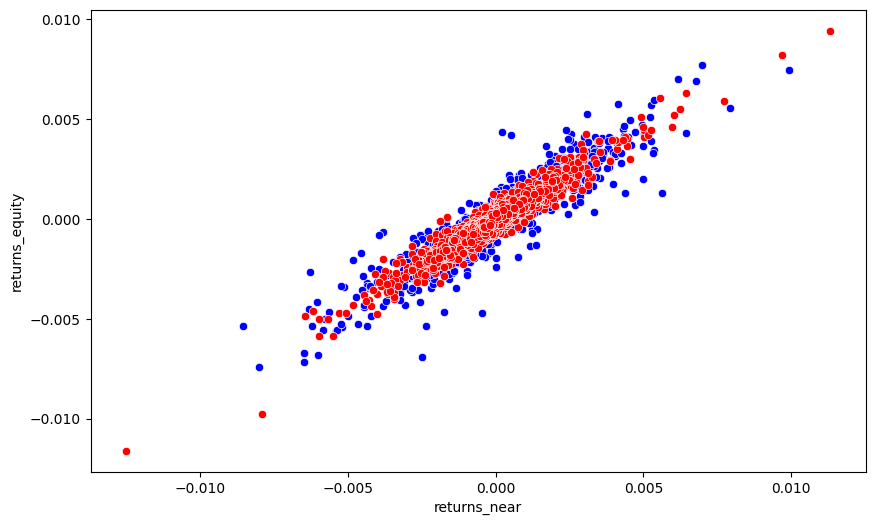

In [24]:
from hyppo.ksample import Energy, KSample
from pandas import Interval

zero_three = final_data.loc[final_data['days_to_expiry_buckets']== Interval(left=0, right=3, closed='left')]
three_six = final_data.loc[final_data['days_to_expiry_buckets']== Interval(left=9, right=12, closed='left')]
bivar_cols = ['returns_near','returns_equity']
plt.figure(figsize=(10,6))
sns.scatterplot(zero_three, x = bivar_cols[0], y =bivar_cols[1], color = 'blue',)
sns.scatterplot(three_six, x = bivar_cols[0], y =bivar_cols[1], color = 'red')
stat, pval = KSample(indep_test ="RV").test(zero_three[bivar_cols].dropna().values, three_six[bivar_cols].dropna().values)
print(stat, pval)

4.84202280074677e-05 0.16283716283716285


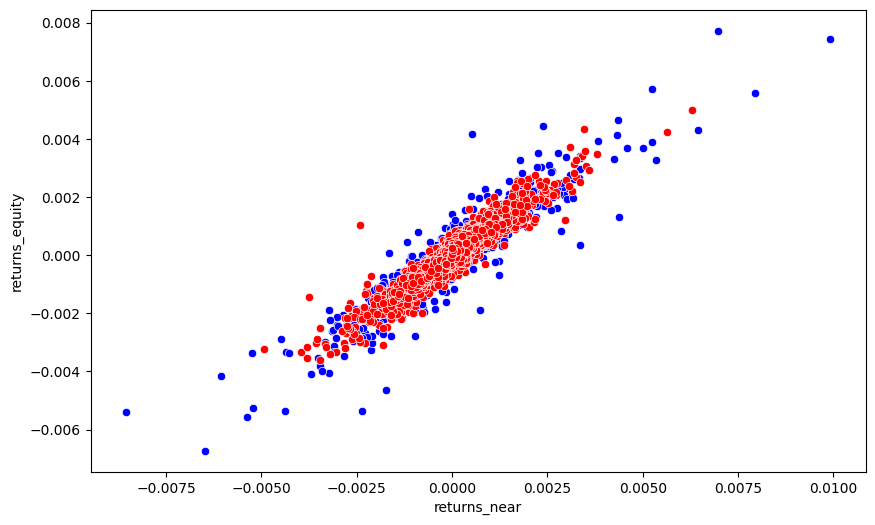

In [26]:
from hyppo.ksample import Energy, KSample
from pandas import Interval

zero_three = final_data.loc[final_data['days_to_expiry']==0]
three_six = final_data.loc[final_data['days_to_expiry']== 8]
bivar_cols = ['returns_near','returns_equity']
plt.figure(figsize=(10,6))
sns.scatterplot(zero_three, x = bivar_cols[0], y =bivar_cols[1], color = 'blue',)
sns.scatterplot(three_six, x = bivar_cols[0], y =bivar_cols[1], color = 'red')
stat, pval = KSample(indep_test ="RV").test(zero_three[bivar_cols].dropna().values, three_six[bivar_cols].dropna().values)
print(stat, pval)

3.018219017242903e-05 0.0989010989010989


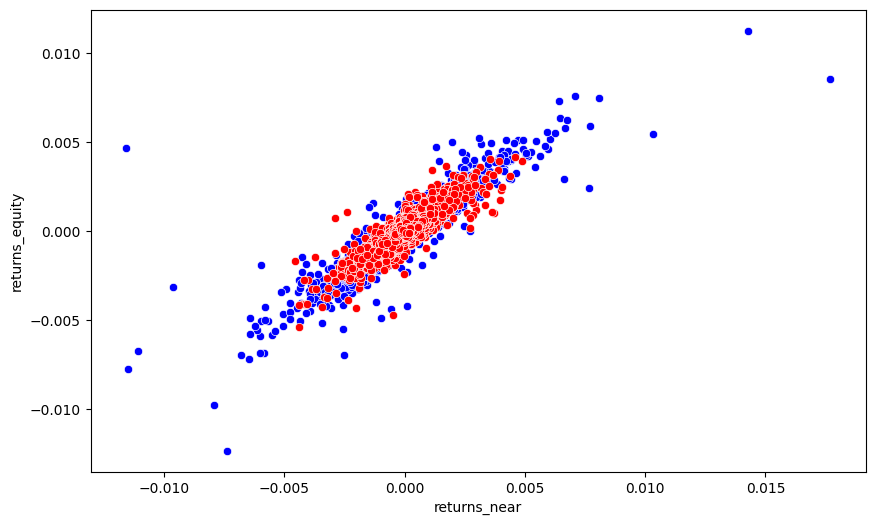

In [102]:
from hyppo.ksample import Energy, KSample
from pandas import Interval

zero_three = final_data.loc[final_data['hour']==9]
three_six = final_data.loc[final_data['hour']== 15]
bivar_cols = ['returns_near','returns_equity']
plt.figure(figsize=(10,6))
sns.scatterplot(zero_three, x = bivar_cols[0], y =bivar_cols[1], color = 'blue',)
sns.scatterplot(three_six, x = bivar_cols[0], y =bivar_cols[1], color = 'red')
stat, pval = KSample(indep_test ="RV").test(zero_three[bivar_cols].dropna().values, three_six[bivar_cols].dropna().values)
print(stat, pval)

3.018219017242903e-05 0.09490509490509491


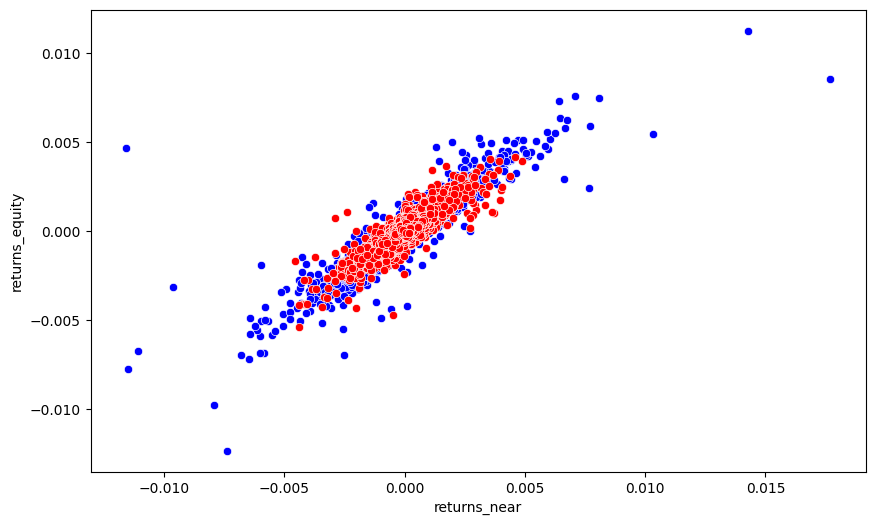

In [ ]:
from hyppo.ksample import Energy, KSample
from pandas import Interval
bivar_cols= ['returns_near', 'returns_equity']
data_copula = final_data[bivar_cols +['hour']].dropna()
zero_three = data_copula.loc[data_copula['hour']==9]
three_six = data_copula.loc[data_copula['hour']== 15]
bivar_cols = ['returns_near','returns_equity']
plt.figure(figsize=(10,6))
sns.scatterplot(zero_three, x = bivar_cols[0], y =bivar_cols[1], color = 'blue',)
sns.scatterplot(three_six, x = bivar_cols[0], y =bivar_cols[1], color = 'red')
stat, pval = KSample(indep_test ="RV").test(zero_three[bivar_cols].dropna().values, three_six[bivar_cols].dropna().values)
print(stat, pval)

<Axes: xlabel='returns_near', ylabel='returns_equity'>

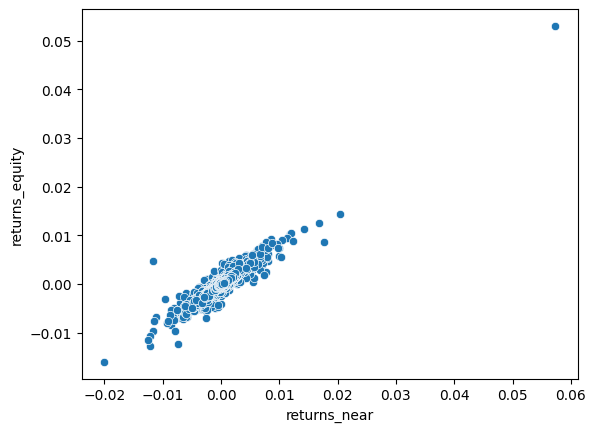

In [25]:
sns.scatterplot(data = final_data, x = 'returns_near', y = 'returns_equity')

In [105]:
final_data.columns

Index(['datetime', 'expiry_date_near', 'stock_code', 'exchange_code',
       'product_type', 'right', 'strike_price', 'open_near', 'high_near',
       'low_near', 'close_near', 'volume_near', 'open_interest_near', 'date',
       'expiry_type', 'MIBOR', 'prev_MIBOR', 'IndexName', 'P/E', 'P/B',
       'Div Yield %', 'close_equity', 'exchange_code_equity', 'high_equity',
       'low_equity', 'open_equity', 'stock_code_equity', 'volume_equity',
       'time_to_expiry', 'open_theoretical_near', 'close_theoretical_near',
       'open_price_diff_near', 'close_price_diff_near', 'open_mid',
       'close_mid', 'high_mid', 'low_mid', 'volume_mid', 'open_interest_mid',
       'expiry_date_mid', 'open_theoretical_mid', 'close_theoretical_mid',
       'open_price_diff_mid', 'close_price_diff_mid', 'open_far', 'close_far',
       'high_far', 'low_far', 'volume_far', 'open_interest_far',
       'expiry_date_far', 'open_theoretical_far', 'close_theoretical_far',
       'open_price_diff_far', 'close_pr

In [35]:
final_data.groupby('hour')[bivar_cols].describe()

returns_near                                                        \
            count          mean       std       min       25%       50%   
hour                                                                      
9         55234.0 -8.906846e-08  0.000576 -0.011591 -0.000250  0.000000   
10        75191.0  4.705648e-07  0.000500 -0.019994 -0.000191  0.000000   
11        75421.0  6.004648e-07  0.000430 -0.021211 -0.000168  0.000000   
12        75397.0  5.154558e-07  0.000433 -0.026915 -0.000170  0.000000   
13        75289.0 -1.701983e-07  0.000441 -0.008555 -0.000186  0.000000   
14        75222.0 -2.094384e-07  0.000483 -0.012530 -0.000204  0.000000   
15        38034.0  3.917818e-06  0.000405 -0.004550 -0.000158  0.000000   
16           60.0  1.773676e-04  0.000801 -0.001378 -0.000369  0.000162   
18          237.0  1.834408e-06  0.000248 -0.000872 -0.000115  0.000000   
19           61.0 -1.552405e-05  0.000208 -0.000505 -0.000129 -0.000028   

                         returns_equity                                    \
           75%       max          count          mean       std       min   
hour                                                                        
9     0.000252  0.017699        54819.0 -2.759760e-06  0.000586 -0.012321   
10    0.000190  0.057317        74693.0 -1.458507e-06  0.000474 -0.016043   
11    0.000169  0.019416        74856.0  7.847324e-07  0.000378 -0.008024   
12    0.000169  0.013072        74858.0  1.288780e-06  0.000362 -0.007708   
13    0.000187  0.007241        74869.0 -3.772010e-07  0.000397 -0.006729   
14    0.000205  0.011333        74800.0 -2.727922e-06  0.000445 -0.011609   
15    0.000169  0.004863        37385.0  4.125442e-06  0.000409 -0.005376   
16    0.000802  0.002145            0.0           NaN       NaN       NaN   
18    0.000110  0.001155            0.0           NaN       NaN       NaN   
19    0.000067  0.000541            0.0           NaN       NaN       NaN   

                                              
           25%       50%       75%       max  
hour                                          
9    -0.000267  0.000000  0.000267  0.011239  
10   -0.000187 -0.000002  0.000184  0.053066  
11   -0.000151  0.000000  0.000153  0.009255  
12   -0.000150  0.000000  0.000150  0.008732  
13   -0.000163  0.000000  0.000165  0.006230  
14   -0.000186 -0.000002  0.000186  0.009423  
15   -0.000175  0.000004  0.000186  0.004182  
16         NaN       NaN       NaN       NaN  
18         NaN       NaN       NaN       NaN  
19         NaN       NaN       NaN       NaN

##### We observe joint distribution dont have statistical significant difference across different times. Hence fitting one copula for all timepoints

In [19]:
from scipy import stats
# Testing if sample mean is different from 0
statistic, pvalue = stats.ttest_1samp(final_data['returns_far'].dropna(), 0)
print(statistic, pvalue)

2.3773117446542607 0.017439888101578573


In [17]:
from scipy import stats
# Testing if sample mean is different from 0
statistic, pvalue = stats.ttest_1samp(final_data['returns_equity'].dropna(), 0)
print(statistic, pvalue)

-0.6137155215563482 0.5394036291300198


In [66]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def test_distribution(data, column_name):
    """
    Test whether a column follows normal or t-distribution
    
    Args:
        data: pandas DataFrame
        column_name: str, name of the column to test
    """
    # Get the data
    values = data[column_name].dropna()
    
    # Plot histogram with normal and t-distribution fits
    plt.figure(figsize=(12, 6))
    
    # Histogram of actual data
    sns.histplot(values, stat='density', label='Actual Data', alpha=0.5)
    
    # Fit normal distribution
    mu, sigma = stats.norm.fit(values)
    x = np.linspace(values.min(), values.max(), 100)
    norm_pdf = stats.norm.pdf(x, mu, sigma)
    plt.plot(x, norm_pdf, 'r-', label=f'Normal (μ={mu:.2f}, σ={sigma:.2f})')
    
    # Fit t-distribution
    df, loc, scale = stats.t.fit(values)
    t_pdf = stats.t.pdf(x, df, loc, scale)
    plt.plot(x, t_pdf, 'g-', label=f't-dist (df={df:.2f})')
    
    plt.title(f'Distribution Test for {column_name}')
    plt.legend()
    
    # Perform statistical tests
    shapiro_stat, shapiro_p = stats.shapiro(values)
    kstest_norm_stat, kstest_norm_p = stats.kstest(values, 'norm')
    kstest_t_stat, kstest_t_p = stats.kstest(values, 't', args=(df,loc, scale))
    
    print(f"\nTest Results for {column_name}:")
    print(f"Shapiro-Wilk test (Normal): stat={shapiro_stat:.4f}, p={shapiro_p:.4f}")
    print(f"KS test (Normal): stat={kstest_norm_stat:.4f}, p={kstest_norm_p:.4f}")
    print(f"KS test (t-dist): stat={kstest_t_stat:.4f}, p={kstest_t_p:.4f}")
    
    if shapiro_p > 0.05:
        print("\nThe data appears to be normally distributed (Shapiro-Wilk test)")
    else:
        print("\nThe data does not appear to be normally distributed (Shapiro-Wilk test)")
    
    
    if kstest_t_p > kstest_norm_p:
        print("The data fits t-distribution better than normal distribution (KS test)")
    else:
        print("The data fits normal distribution better than t-distribution (KS test)")

    return shapiro_p, kstest_t_p, kstest_norm_p
# Example usage - replace 'returns' with your column name
# test_distribution(final_data, 'returns_near')

c:\Users\Preet Lodaya\Quant\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 470146.
  res = hypotest_fun_out(*samples, **kwds)



Test Results for returns_near:
Shapiro-Wilk test (Normal): stat=0.7729, p=0.0000
KS test (Normal): stat=0.4980, p=0.0000
KS test (t-dist): stat=0.0064, p=0.0000

The data does not appear to be normally distributed (Shapiro-Wilk test)
The data fits t-distribution better than normal distribution (KS test)


(np.float64(6.989564647714425e-170),
 np.float64(2.3246842691390398e-17),
 np.float64(0.0))

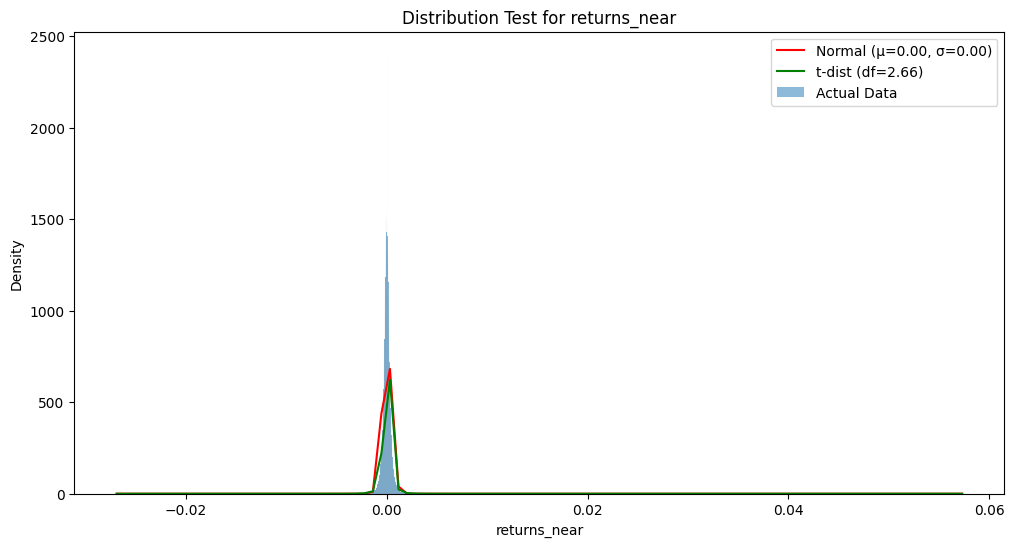

In [69]:
test_distribution(final_data, 'returns_near')


Test Results for returns_equity:
Shapiro-Wilk test (Normal): stat=0.8525, p=0.0000
KS test (Normal): stat=0.4819, p=0.0000
KS test (t-dist): stat=0.0159, p=0.9089

The data does not appear to be normally distributed (Shapiro-Wilk test)
The data fits t-distribution better than normal distribution (KS test)


(np.float64(1.9920510769341783e-32),
 np.float64(0.9089310920989707),
 np.float64(3.0123186032356702e-264))

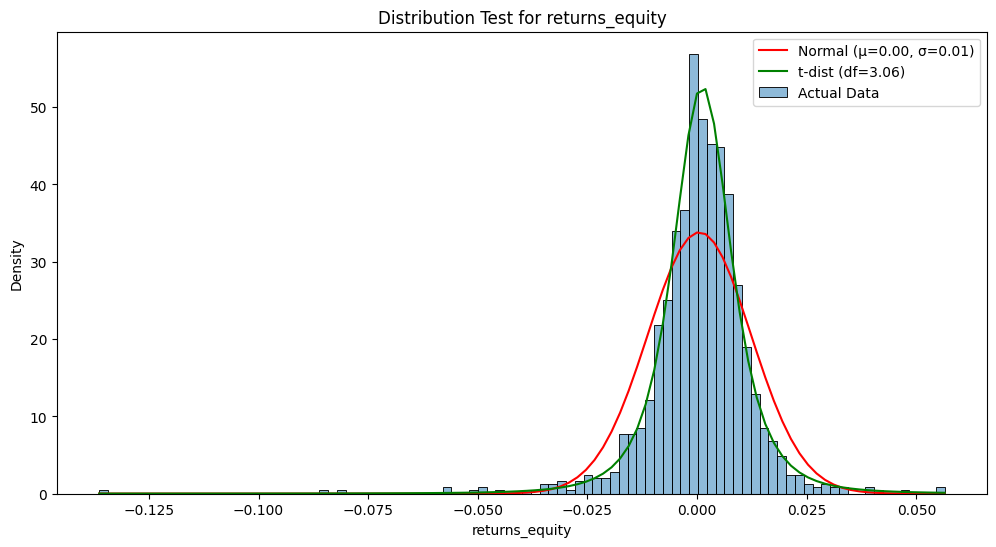

In [67]:
test_distribution(final_data_1d, 'returns_equity')

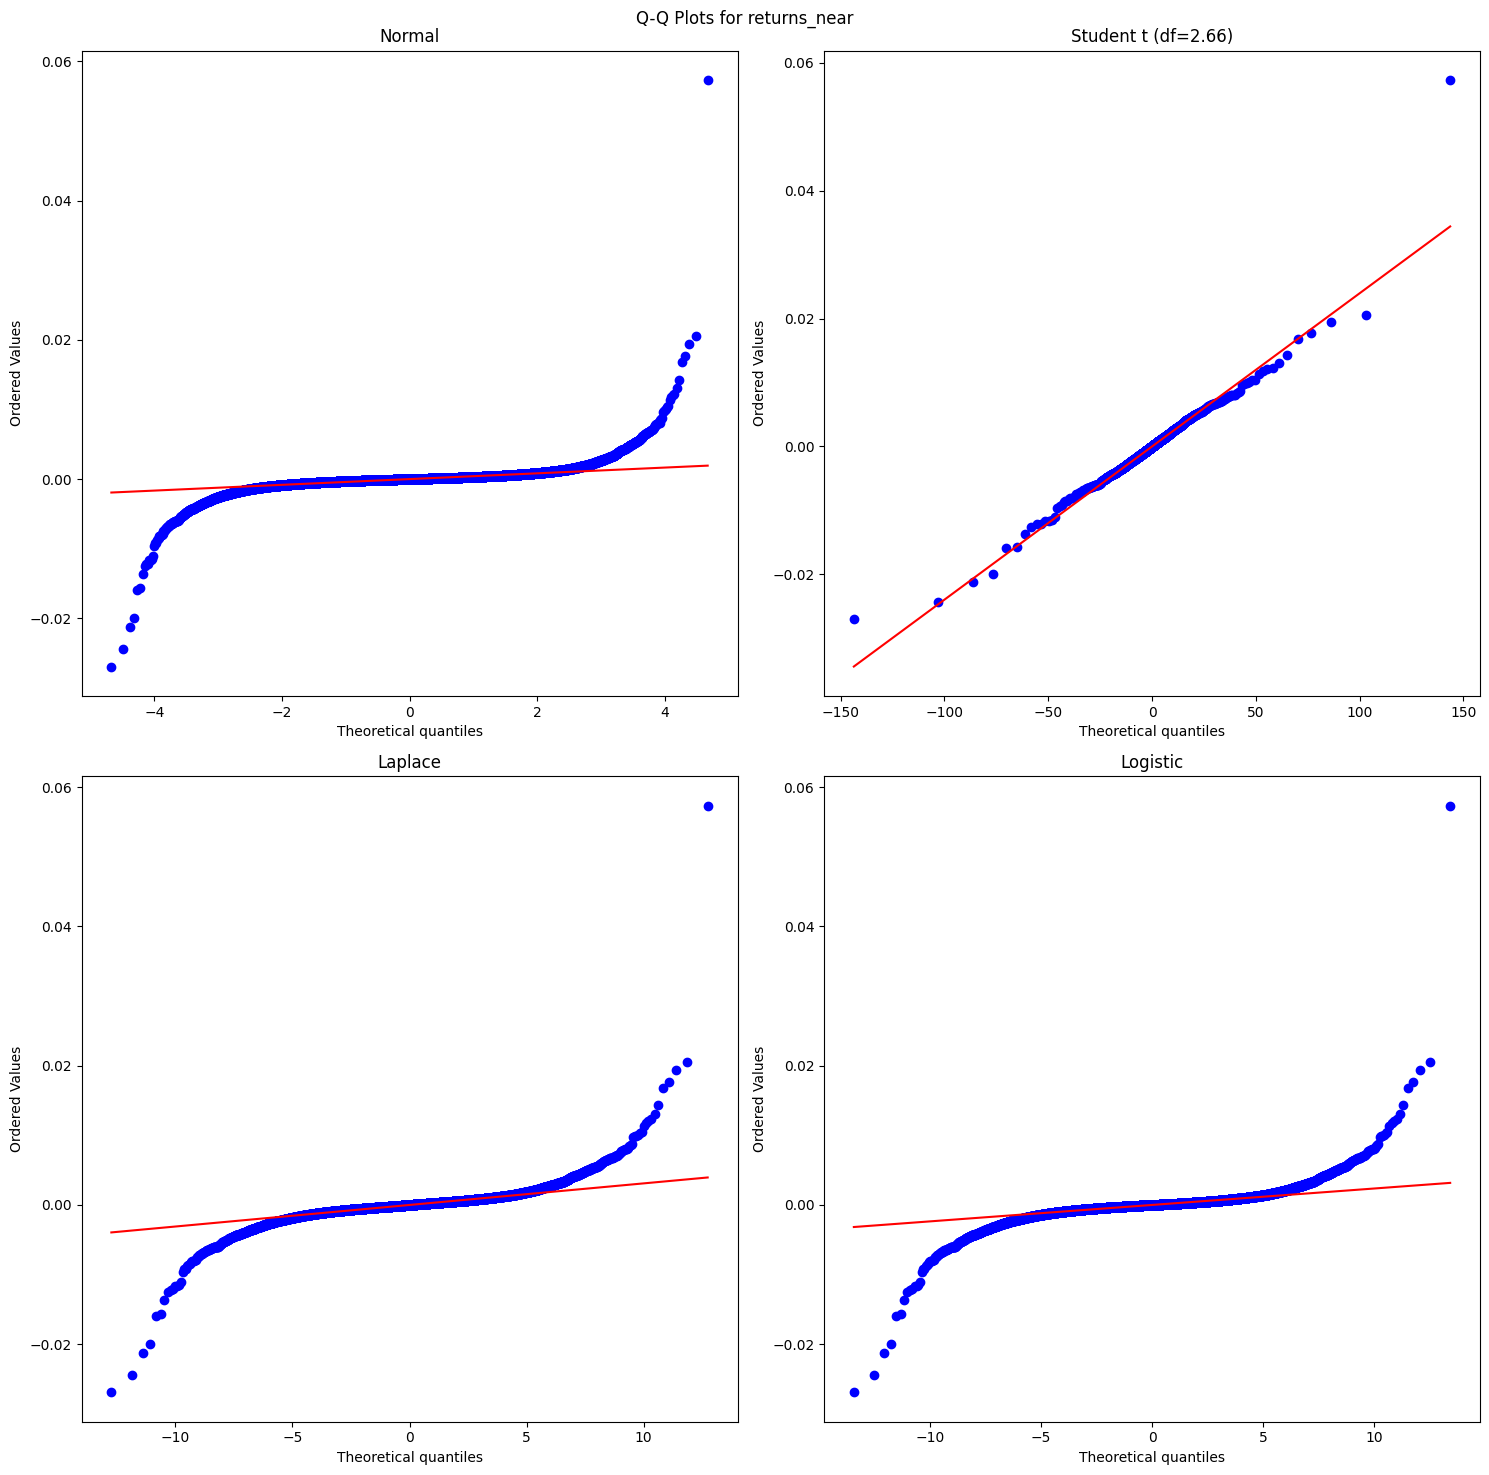

In [49]:
import scipy.stats as stats
def compare_qq_plots(data, column_name):
    """Compare Q-Q plots for different distributions"""
    values = data[column_name].dropna()
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle(f'Q-Q Plots for {column_name}')
    
    # Normal Q-Q plot
    stats.probplot(values, dist="norm", plot=axes[0,0])
    axes[0,0].set_title('Normal')
    
    # Student's t Q-Q plot
    df, loc, scale = stats.t.fit(values)
    stats.probplot(values, dist="t", sparams=(df,), plot=axes[0,1])
    axes[0,1].set_title(f'Student t (df={df:.2f})')
    
    # Laplace Q-Q plot
    stats.probplot(values, dist="laplace", plot=axes[1,0])
    axes[1,0].set_title('Laplace')
    
    # Logistic Q-Q plot
    stats.probplot(values, dist="logistic", plot=axes[1,1])
    axes[1,1].set_title('Logistic')
    
    plt.tight_layout()
    plt.show()
compare_qq_plots(final_data, 'returns_near')

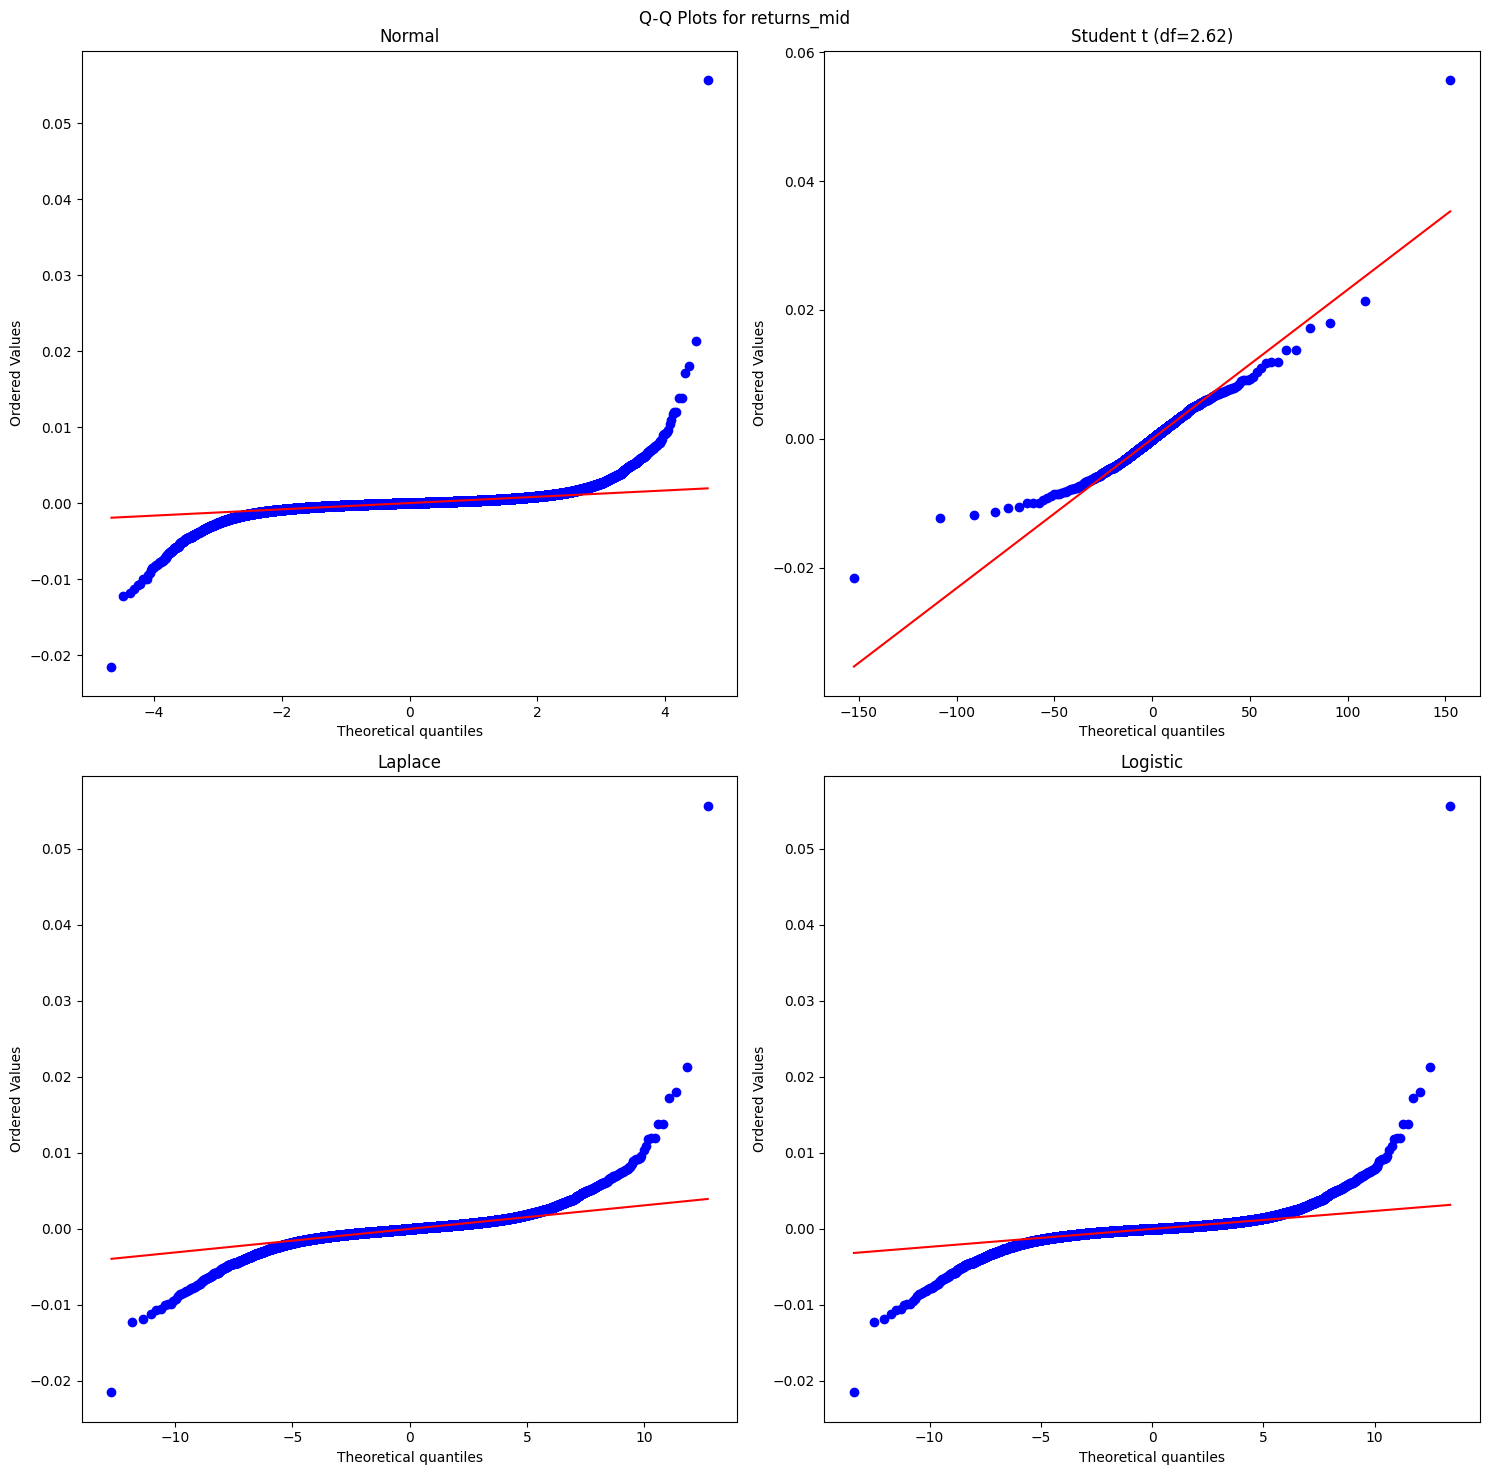

In [48]:
compare_qq_plots(final_data, 'returns_mid')

In [56]:
from copulas.univariate import Univariate

univariate = Univariate()
univariate.fit(final_data_1d['returns_equity'].dropna())
univariate.to_dict()['type']

c:\Users\Preet Lodaya\Quant\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:795: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\Preet Lodaya\Quant\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:800: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


'copulas.univariate.student_t.StudentTUnivariate'

In [61]:
cols = ['returns_near','returns_mid','returns_far','returns_equity']
for col in cols:
    univariate = Univariate()
    univariate.fit(final_data_1d[col].dropna())
    print(univariate.to_dict()['type'])

c:\Users\Preet Lodaya\Quant\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:795: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\Preet Lodaya\Quant\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:800: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


copulas.univariate.student_t.StudentTUnivariate


c:\Users\Preet Lodaya\Quant\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:795: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\Preet Lodaya\Quant\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:800: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


copulas.univariate.student_t.StudentTUnivariate


c:\Users\Preet Lodaya\Quant\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:795: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\Preet Lodaya\Quant\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:800: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


copulas.univariate.student_t.StudentTUnivariate


c:\Users\Preet Lodaya\Quant\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:795: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\Preet Lodaya\Quant\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:800: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


copulas.univariate.student_t.StudentTUnivariate


In [65]:
cols = ['returns_near','returns_mid','returns_far','returns_equity']
for col in cols:
    univariate = Univariate()
    univariate.fit(final_data[col].dropna())
    print(univariate.to_dict()['type'])

c:\Users\Preet Lodaya\Quant\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:800: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


copulas.univariate.student_t.StudentTUnivariate


c:\Users\Preet Lodaya\Quant\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:800: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
c:\Users\Preet Lodaya\Quant\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:6730: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)


copulas.univariate.student_t.StudentTUnivariate


c:\Users\Preet Lodaya\Quant\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:800: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


copulas.univariate.student_t.StudentTUnivariate


c:\Users\Preet Lodaya\Quant\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:800: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


copulas.univariate.student_t.StudentTUnivariate


Clayton Copula θ: 2.8743 | Log-Likelihood: 287315.70
Gumbel Copula θ: 3.1249 | Log-Likelihood: 320136.64
Kendall’s tau: 0.660
Pearson's Correlation: 0.942
Clayton θ from τ: 3.884
Gumbel θ from τ: 2.942


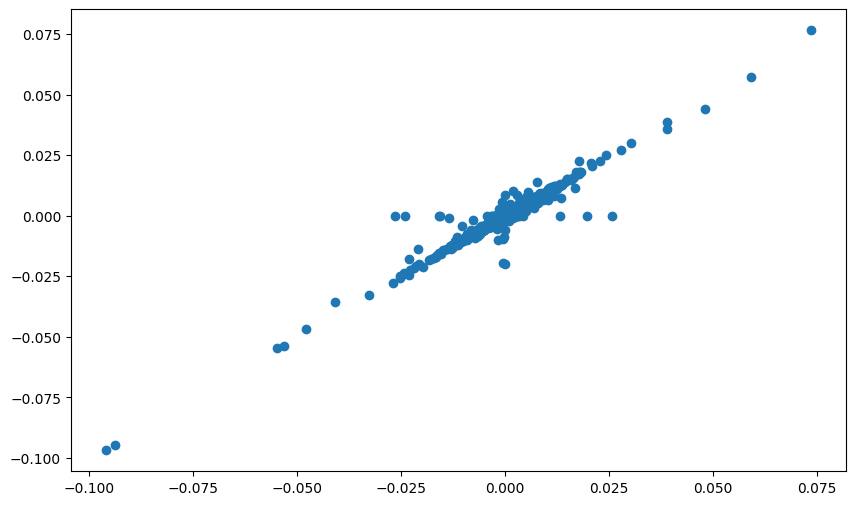

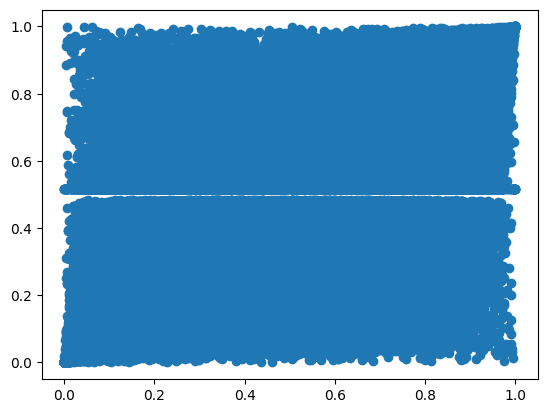

In [38]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import kendalltau, pearsonr
from statsmodels.distributions.empirical_distribution import ECDF

# Step 1: Simulate some bivariate data (you can replace this with real data)
np.random.seed(40)
bivar_cols= ['returns_near', 'returns_mid']
data['hour'] = data[col_dict['time_col']].dt.hour
data_copula = data[bivar_cols +['hour']].dropna()
x = data_copula[bivar_cols[0]].values
y = data_copula[bivar_cols[1]].values

# Step 2: Transform to uniform marginals using empirical CDFs
ecdf_x = ECDF(x)
ecdf_y = ECDF(y)
u = ecdf_x(x)
v = ecdf_y(y)

# Clip to avoid log(0) or division by 0 in density formulas
eps = 1e-10
u = np.clip(u, eps, 1 - eps)
v = np.clip(v, eps, 1 - eps)

# Step 3a: Clayton copula log-likelihood
def clayton_log_likelihood(theta):
    if theta <= 0:
        return np.inf
    term = u**(-theta) + v**(-theta) - 1
    log_c = np.log(theta + 1) - (theta + 1) * (np.log(u) + np.log(v)) - (2 + 1/theta) * np.log(term)
    return -np.sum(log_c)

# Step 3b: Gumbel copula log-likelihood
def gumbel_log_likelihood(theta):
    if theta < 1:
        return np.inf
    log_u = -np.log(u)
    log_v = -np.log(v)
    t = (log_u**theta + log_v**theta)**(1/theta)
    C = np.exp(-t)
    
    part1 = C
    part2 = (log_u * log_v)**(theta - 1)
    part3 = (log_u**theta + log_v**theta)**(2 - 1/theta)
    log_c = np.log(part1) + (theta - 1) * (np.log(log_u) + np.log(log_v)) \
            - np.log(u) - np.log(v) + np.log(theta) - np.log(part3)
    return -np.sum(log_c)

# Step 4: Fit both copulas using MLE
clayton_res = minimize(clayton_log_likelihood, x0=[1.0], bounds=[(0.01, 10)])
gumbel_res = minimize(gumbel_log_likelihood, x0=[1.5], bounds=[(1.01, 10)])

# Step 5: Print results
print(f"Clayton Copula θ: {clayton_res.x[0]:.4f} | Log-Likelihood: {-clayton_res.fun:.2f}")
print(f"Gumbel Copula θ: {gumbel_res.x[0]:.4f} | Log-Likelihood: {-gumbel_res.fun:.2f}")

# Optional: Also estimate theta from Kendall's tau for reference
tau, _ = kendalltau(x, y)
corr, _ = pearsonr(x,y)
clayton_theta_kendall = 2 * tau / (1 - tau)
gumbel_theta_kendall = 1 / (1 - tau)

print(f"Kendall’s tau: {tau:.3f}")
print(f"Pearson's Correlation: {corr:.3f}")
print(f"Clayton θ from τ: {clayton_theta_kendall:.3f}")
print(f"Gumbel θ from τ: {gumbel_theta_kendall:.3f}")
plt.figure(figsize=(10,6))
plt.scatter(x,y)
plt.show()
plt.scatter(u,v)
plt.show()

In [15]:
from copulae import StudentCopula,GaussianCopula
sc = GaussianCopula(dim = 2)
sc.fit(data_copula[bivar_cols].dropna().values)
print(sc.summary())
sc._fit_smry

Gaussian Copula Summary
Gaussian Copula with 2 dimensions


Parameters
--------------------------------------------------------------------------------
 Correlation Matrix 
1.000000 0.833801
0.833801 1.000000



Fit Summary                                   
================================================================================
Log. Likelihood      : 326162.123088599
Method               : Maximum likelihood
Data Points          : 471409

Optimization Setup
--------------------------------------------------------------------------------
	bounds         : [(np.float64(-1.000001), np.float64(1.000001))]
	options        : {'maxiter': 20000, 'ftol': 1e-06, 'iprint': 1, 'disp': False, 'eps': 1.5e-08}
	method         : SLSQP

Results
--------------------------------------------------------------------------------
	x              : [0.83380063]
	fun            : -326162.123088599
	jac            : [-307631.31370394]
	nit            : 5
	nfev           : 2
	njev           : 1
	status         : 0
	message        : Optimization terminated successfully
	success        : True

In [ ]:
from copulae import ClaytonCopula, GumbelCopula
sc = GumbelCopula(dim = 2)
sc.fit(data_copula[bivar_cols])
print(sc.summary())
sc._fit_smry
sampled_data = sc.random(data_copula.shape[0])
from hyppo.ksample import Energy, KSample
stat, pval = KSample(indep_test ="RV").test(ECDF[data_copula[bivar_cols].values], ECDF[sampled_data[bivar_cols].values])
print(stat, pval)

        returns_near  returns_equity
count  466280.000000   466280.000000
mean        0.500000        0.500000
std         0.288675        0.288675
min         0.000002        0.000002
25%         0.250001        0.250001
50%         0.500361        0.499805
75%         0.749999        0.749999
max         0.999998        0.999998
Gumbel Copula Summary
Gumbel Copula with 2 dimensions


Parameters
--------------------------------------------------------------------------------
       theta        : 3.502015014512266

0.6146950937294348 0.000999000999000999


<Axes: xlabel='returns_near', ylabel='returns_equity'>

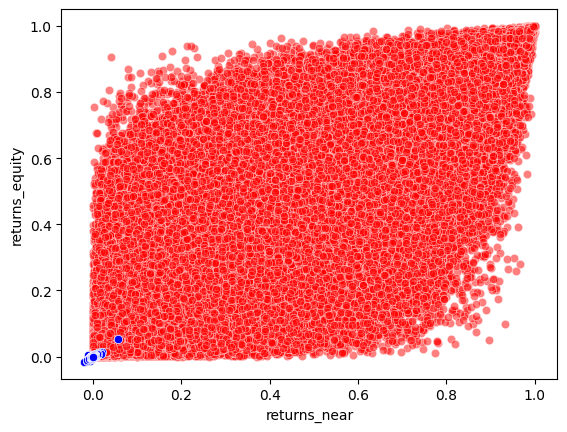

In [ ]:
sns.scatterplot(sampled_data, x = bivar_cols[0], y =bivar_cols[1], color = 'red',alpha = 0.5)
sns.scatterplot(data_copula, x = bivar_cols[0], y =bivar_cols[1], color = 'blue',)

In [91]:
from copulae import ClaytonCopula, GumbelCopula, StudentCopula, FrankCopula, GaussianCopula
from statsmodels.distributions.empirical_distribution import ECDF
sc = GaussianCopula(dim = 2)

# Define the bivariate columns
bivar_cols = ['returns_near', 'returns_mid']

# Prepare the data
data_copula = data[bivar_cols].dropna()
x = data_copula[bivar_cols[0]].values
y = data_copula[bivar_cols[1]].values
ecdf_x = ECDF(x)
ecdf_y = ECDF(y)
# u = ecdf_x(x)
# v = ecdf_y(y)
eps = 1e-10
u = np.clip(ecdf_x(x), eps, 1 - eps)
v = np.clip(ecdf_y(y), eps, 1 - eps)
copula_uv = np.column_stack((u,v))
sc.fit(copula_uv, method='ml', to_pobs=False, verbose=3)
print(sc.summary())
sc._fit_smry

# sampled_data = sc.random(data_copula.shape[0],)
# from hyppo.ksample import Energy, KSample
# stat, pval = KSample(indep_test ="RV").test(ECDF(data_copula[bivar_cols[0]].values)(data_copula[bivar_cols[0]].values), 
#                                             ECDF(data_copula[bivar_cols[1]].values)(data_copula[bivar_cols[1]].values))
# print(stat, pval)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -326095.1496655069
            Iterations: 5
            Function evaluations: 2
            Gradient evaluations: 1
Gaussian Copula Summary
Gaussian Copula with 2 dimensions


Parameters
--------------------------------------------------------------------------------
 Correlation Matrix 
1.000000 0.833723
0.833723 1.000000



Fit Summary                                   
================================================================================
Log. Likelihood      : 326095.1496655069
Method               : Maximum likelihood
Data Points          : 471409

Optimization Setup
--------------------------------------------------------------------------------
	bounds         : [(np.float64(-1.000001), np.float64(1.000001))]
	options        : {'maxiter': 20000, 'ftol': 1e-06, 'iprint': 1, 'disp': True, 'eps': 1.5e-08}
	method         : SLSQP

Results
--------------------------------------------------------------------------------
	x              : [0.83372261]
	fun            : -326095.1496655069
	jac            : [-307576.68387399]
	nit            : 5
	nfev           : 2
	njev           : 1
	status         : 0
	message        : Optimization terminated successfully
	success        : True

In [67]:
print(copula_uv.min(axis=0), copula_uv.max(axis=0))  # Should be within [0, 1]

[2.12130019e-06 2.12130019e-06] [1. 1.]


In [92]:
x_val = 0.0002
ecdf_x(x_val)

np.float64(0.759781845488737)

In [88]:
pd.Series(ecdf_x.x).describe()

c:\Users\Preet Lodaya\Quant\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    4.714100e+05
mean             -inf
std               NaN
min              -inf
25%     -1.878393e-04
50%      0.000000e+00
75%      1.896846e-04
max      7.340043e-02
dtype: float64

In [5]:
sc.pdf([ecdf_x(x_val), ecdf_y(y_val)])

NameError: name 'x_val' is not defined

In [6]:
x_val = 0.0001
y_val = 0.0003
sc.pobs([x_val, y_val])

array([0.33333333, 0.66666667])

In [98]:
sc.pdf(sc.pobs([x_val, y_val]))

0.5777466376471677

In [ ]:
x_val = 0.000001
y_val = 0.000003
sc.pobs([x_val, y_val])

array([0.33333333, 0.66666667])

In [59]:
data_copula[bivar_cols].describe()

returns_near    returns_mid
count  471409.000000  471409.000000
mean        0.000002       0.000002
std         0.000629       0.000620
min        -0.095878      -0.096814
25%        -0.000188      -0.000184
50%         0.000000       0.000000
75%         0.000190       0.000186
max         0.073400       0.076522

In [82]:
u[u<=(1.1*eps)]

array([], dtype=float64)

In [85]:
u

array([0.03707821, 0.31377636, 0.84280317, ..., 0.56994669, 0.73308104,
       0.93871776], shape=(471409,))

In [ ]:
sc.

In [95]:
from scipy.integrate import quad, dblquad
import numpy as np

from functools import partial

def pdf(x,y):
    eps = 1e-10
    # print(ecdf_x(x), ecdf_y(y))
    # print(x,y)
    return sc.pdf(np.array([np.clip(ecdf_x(x),eps, 1 - eps),
                   np.clip(ecdf_y(y), eps, 1 - eps)]), log=False)
    # return sc.pdf([x,y], log=False)
x_val = 0.0001
y_val = 0.0003
pdf_fixed_y = partial(pdf, y = y_val)


numerator,error,info, message = quad(pdf_fixed_y, -np.inf, x_val, full_output=1,
                                     limit = 1000, 
                                     epsabs=1e-10,
                                     epsrel=1e-10)

denominator = numerator + quad(pdf_fixed_y, x_val, np.inf)[0]

print(numerator / denominator)

# # Example usage
# if __name__ == "__main__":
#     # Define a sample PDF (e.g., standard normal distribution)
#     from scipy.stats import norm
#     pdf = norm.pdf  # Standard normal PDF

#     # Calculate the CDF for a given value
#     x_value = 1.0  # Example: Calculate CDF at x = 1.0
#     cdf_value = calculate_cdf(pdf, x_value)
#     print(f"CDF at x = {x_value}: {cdf_value}")

0.04653073247754892


C:\Users\Preet Lodaya\AppData\Local\Temp\ipykernel_12500\364224706.py:23: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  denominator = numerator + quad(pdf_fixed_y, x_val, np.inf)[0]


In [93]:
print('quad additional information:-',info)
print('quad message:-',message)

quad additional information:- {'neval': 735, 'last': 25, 'iord': array([         0,         17,         13,         18,         11,
               14,         19,         20,          9,         21,
               15,          8,         16,         12,         24,
               22,         23,         10,          7,          6,
                5,          4,          1,          2,          3,
        926103862,  825058614,  537537593,  538976288,  774971424,
        959983921,  842478644,  875638117,  774971436,  809054260,
        909325621,  959524197,  775036972,  943141682,  859060536,
        875638117,  775168044,  926232625,  926036788,  942681445,
        538970668,  538976288,  875443232,  926364983, 1698117688,
        741617965,  959329312,  858927157, 1698247475,  741945389,
        959328800,  942814513, 1697986870,  741356077,  959330336,
        892678453, 1697920823,  741617965,  538976266,  538976288,
        825634353,  943141941,  761608504,  539769136,  96004869

In [94]:
error

7.685859877505863e-05

In [61]:
ecdf_x(x_val), x_val

(np.float64(0.646470474683343), 0.0001)

In [ ]:
quad(pdf_fixed_y, -np.inf, x_val, limit = 1000,  epsabs=1e-10, epsrel=1e-10, )

C:\Users\Preet Lodaya\AppData\Local\Temp\ipykernel_12500\3149473941.py:1: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad(pdf_fixed_y, -np.inf, x_val, limit = 2000,  epsabs=1e-10, epsrel=1e-10)


(-4.1952973724341284e-05, 1.4883743941220116e-05)

In [ ]:
from scipy.stats import norm

def test_quad(x,y):
    print(x,y)
    return norm.pdf(x, loc=0, scale=1) + y

test_quad_partial = partial(test_quad, y = 5)

quad(test_quad_partial, -np.inf,np.inf, li)

1.0 5
-1.0 5
233.0651686899483 5
0.0042906454260024365 5
-233.0651686899483 5
-0.0042906454260024365 5
38.29883980138545 5
0.026110451522446055 5
-38.29883980138545 5
-0.026110451522446055 5
13.799951646519888 5
0.07246402202084402 5
-13.799951646519888 5
-0.07246402202084402 5
6.737877409458626 5
0.14841469193194298 5
-6.737877409458626 5
-0.14841469193194298 5
3.8319360294671116 5
0.26096469051417465 5
-3.8319360294671116 5
-0.26096469051417465 5
2.366125858665451 5
0.42263178703605525 5
-2.366125858665451 5
-0.42263178703605525 5
1.5245670511343803 5
0.655923922306948 5
-1.5245670511343803 5
-0.655923922306948 5
3.0 5
-3.0 5
467.1303373798966 5
1.0085812908520049 5
-467.1303373798966 5
-1.0085812908520049 5
77.5976796027709 5
1.0522209030448921 5
-77.5976796027709 5
-1.0522209030448921 5
28.59990329303978 5
1.144928044041688 5
-28.59990329303978 5
-1.144928044041688 5
14.475754818917252 5
1.2968293838638858 5
-14.475754818917252 5
-1.2968293838638858 5
8.663872058934224 5
1.52192938

C:\Users\Preet Lodaya\AppData\Local\Temp\ipykernel_12500\461522201.py:9: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad(test_quad_partial, -np.inf,np.inf)


(-9.0, 3.7504463534787646e-08)

C:\Users\Preet Lodaya\AppData\Local\Temp\ipykernel_12500\3771530336.py:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad(pdf_fixed_y, x_val, 100*x_val)


(0.021510336567251376, 8.105482618425697e-08)

In [42]:
denominator

-2.1139666875498784

In [51]:
quad(pdf_fixed_y, a = 0,b = x_val)

0.5763190774889746 0.842523159294795
0.5061316181914219 0.842523159294795
0.6448773782426725 0.842523159294795
0.515229874694798 0.842523159294795
0.6380086082361601 0.842523159294795
0.5280298000250314 0.842523159294795
0.6251683782023678 0.842523159294795
0.5453777929568592 0.842523159294795
0.6084313197244856 0.842523159294795
0.5654813548320037 0.842523159294795
0.5881559325341689 0.842523159294795
0.5061316181914219 0.842523159294795
0.6462731937659231 0.842523159294795
0.51002208273495 0.842523159294795
0.6420942323969208 0.842523159294795
0.5209722343018484 0.842523159294795
0.632308674632856 0.842523159294795
0.5359189154216403 0.842523159294795
0.6168740944699825 0.842523159294795
0.5549342503006943 0.842523159294795
0.5987942529735326 0.842523159294795
0.5402697021058147 0.842523159294795
0.5061316181914219 0.842523159294795
0.5754854065153614 0.842523159294795
0.5099011686242733 0.842523159294795
0.5717391903845706 0.842523159294795
0.516417802799692 0.842523159294795
0.5647

(6.977611433544152e-05, 5.047504136377712e-09)

In [39]:
pdf_fixed_y(0.00005)

0.5763190774889746 0.842523159294795


0.6610957349056711

In [29]:
quad(pdf_fixed_y, -np.inf,x_val)

0.0 0.842523159294795
0.0 0.842523159294795
0.000767910667806512 0.842523159294795
0.0 0.842523159294795
1.909170168579726e-05 0.842523159294795
0.0 0.842523159294795
4.2426003746216135e-06 0.842523159294795
0.0 0.842523159294795
0.0 0.842523159294795
0.0 0.842523159294795
0.0 0.842523159294795
0.0 0.842523159294795
0.0 0.842523159294795
0.0 0.842523159294795
0.0 0.842523159294795
0.0 0.842523159294795
0.0 0.842523159294795
0.0 0.842523159294795
0.0 0.842523159294795
0.0 0.842523159294795
0.0 0.842523159294795
0.0 0.842523159294795
0.0 0.842523159294795
0.0 0.842523159294795
0.0 0.842523159294795
0.0 0.842523159294795
0.0 0.842523159294795
0.0 0.842523159294795
0.0 0.842523159294795
0.0 0.842523159294795
0.0 0.842523159294795
0.0 0.842523159294795
0.0033007430914556153 0.842523159294795
0.0 0.842523159294795
8.485200749243226e-05 0.842523159294795
0.0 0.842523159294795
1.2727801123864841e-05 0.842523159294795
0.0 0.842523159294795
4.2426003746216135e-06 0.842523159294795
0.0 0.84252315

C:\Users\Preet Lodaya\AppData\Local\Temp\ipykernel_12500\1595762531.py:1: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad(pdf_fixed_y, -np.inf,x_val)


(nan, nan)

In [38]:
pdf(x_val, y_val)

0.646470474683343 0.842523159294795


1.1670565376920743

In [96]:
pdf_fixed_y(x_val)

1.159697662187771

In [23]:
quad(pdf_fixed_y, -np.inf, x_val)

C:\Users\Preet Lodaya\AppData\Local\Temp\ipykernel_11868\1731253729.py:1: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad(pdf_fixed_y, -np.inf, x_val)


(nan, nan)

In [ ]:
from statsmodels.distributions.copula.api import CopulaDistribution, StudentTCopula
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np

# Define the bivariate columns
bivar_cols = ['returns_near', 'returns_equity']

# Prepare the data
data_copula = final_data[bivar_cols].dropna()
x = data_copula[bivar_cols[0]].values
y = data_copula[bivar_cols[1]].values
u = ECDF(x)(x)
v = ECDF(y)(y)
copula_data = np.column_stack((u, v))

# Fit a Student's t copula
copula = StudentTCopula(k_dim=2)
copula.fit_corr_param(data_copula,)

# # Generate random samples from the fitted copula
# sampled_data = copula.random(len(data_copula))

# # Print copula parameters
# print("Fitted Copula Parameters:")
# print(f"Correlation Matrix:\n{copula.corr}")
# print(f"Degrees of Freedom: {copula.df}")

# # Perform a goodness-of-fit test using KSample
# from hyppo.ksample import KSample

# stat, pval = KSample(indep_test="RV").test(copula_data, sampled_data)
# print(f"Goodness-of-Fit Test Statistic: {stat}, p-value: {pval}")

# # Plot the original and sampled data
# import matplotlib.pyplot as plt
# import seaborn as sns

# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=copula_data[:, 0], y=copula_data[:, 1], color='blue', label='Original Data', alpha=0.5)
# sns.scatterplot(x=sampled_data[:, 0], y=sampled_data[:, 1], color='red', label='Sampled Data', alpha=0.5)
# plt.legend()
# plt.title("Original vs Sampled Data from Student's t Copula")
# plt.show()

np.float64(0.99999999608494)

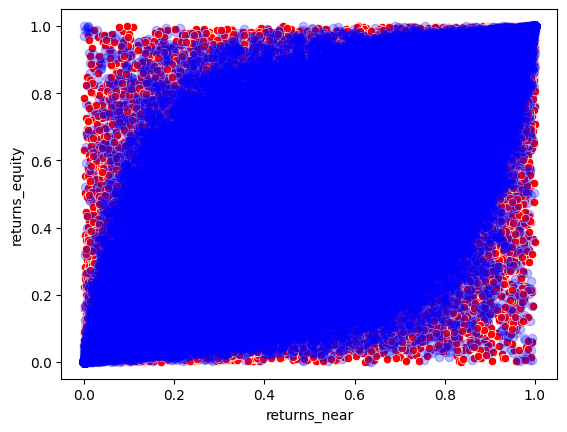

In [45]:
sns.scatterplot(sampled_data, x = bivar_cols[0], y =bivar_cols[1], color = 'red')
plt.scatter(u,v, color = 'blue',alpha = 0.25)

In [ ]:
final_data_1d.columns

Index(['datetime', 'open_near', 'high_near', 'low_near', 'close_near',
       'volume_near', 'open_interest_near', 'expiry_date_near', 'date',
       'returns', 'log_returns', 'overnight_returns', 'overnight_log_returns',
       'intraday_returns', 'intraday_log_returns', 'expiry_type', 'MIBOR',
       'prev_MIBOR', 'IndexName', 'P/E', 'P/B', 'Div Yield %',
       'datetime_equity', 'open_equity', 'high_equity', 'low_equity',
       'close_equity', 'volume_equity', 'returns_equity', 'log_returns_equity',
       'overnight_returns_equity', 'overnight_log_returns_equity',
       'intraday_returns_equity', 'intraday_log_returns_equity',
       'time_to_expiry', 'open_theoretical_near', 'close_theoretical_near',
       'open_price_diff_near', 'close_price_diff_near', 'open_mid',
       'close_mid', 'high_mid', 'low_mid', 'volume_mid', 'open_interest_mid',
       'expiry_date_mid', 'open_theoretical_mid', 'close_theoretical_mid',
       'open_price_diff_mid', 'close_price_diff_mid', 'open_f

In [34]:
print((x == y).all())  # True if all values are identical
print(x.corr(y, method='spearman'))  # Should also be 1 or very close

False


AttributeError: 'numpy.ndarray' object has no attribute 'corr'

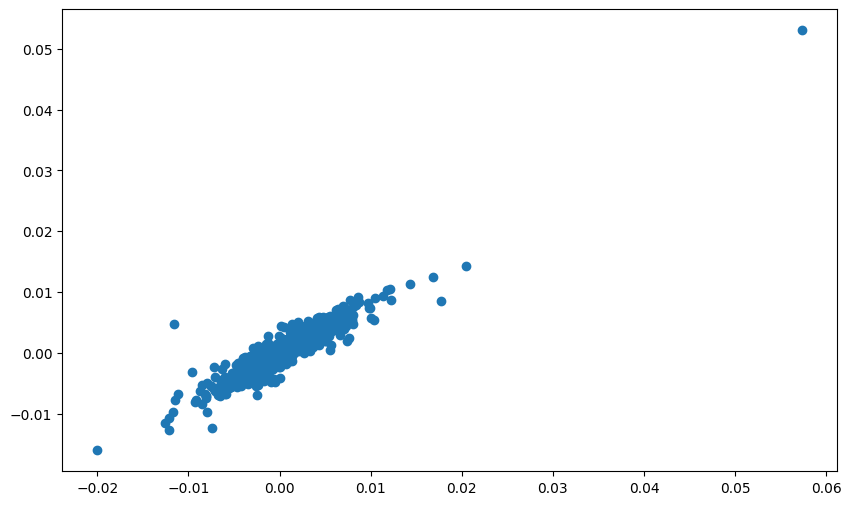

In [76]:
from copulas.bivariate import Bivariate, Gumbel
bi = Bivariate()
bi.fit(X = final_data_1d[['returns_near','returns_equity']].dropna().values)

ValueError: Marginal value out of bounds.

In [57]:
from copulas.univariate import Univariate

univariate = Univariate()
univariate.fit((final_data_1d[f"{col_dict['close_price_col']}_equity"]/final_data_1d[f"{col_dict['close_price_col']}_equity"].shift(1)).dropna())
univariate.to_dict()['type']

c:\Users\Preet Lodaya\Quant\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:795: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\Preet Lodaya\Quant\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:800: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


'copulas.univariate.student_t.StudentTUnivariate'

In [ ]:
univariate.to_dict()['type']

[2.01280749e-06 8.66239611e-06 1.00247779e-05 ... 8.12916250e-02
 8.58416476e-02 1.36328867e-01]


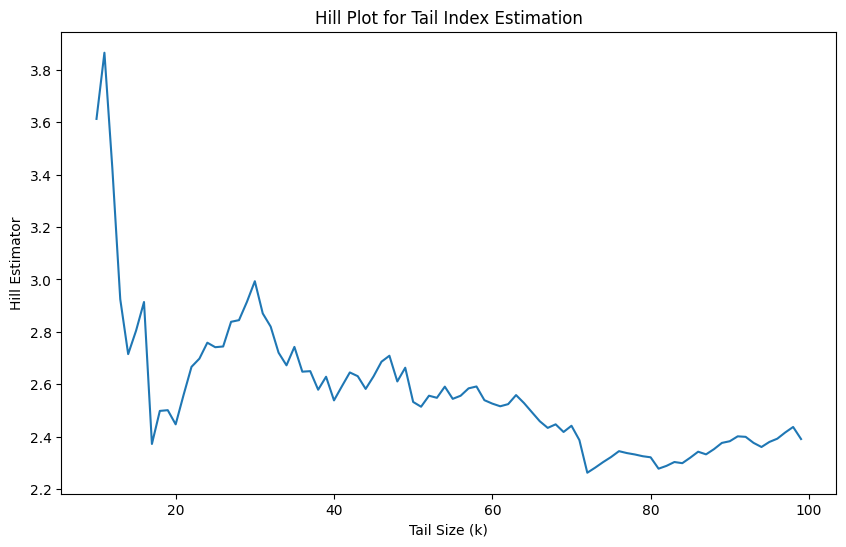

In [54]:
def analyze_tail_behavior(data, column_name):
    """Analyze tail behavior using Hill estimator"""
    values = np.abs(data[column_name].dropna()).sort_values().values
    # values
    n = len(values)
    print(values)
    # Calculate Hill estimator for different tail sizes
    k_values = range(10, min(100, n//2))
    hill_estimators = []
    
    for k in k_values:
        threshold = values[-k]
        tail_data = values[values >= threshold]
        hill = 1/np.mean(np.log(tail_data/threshold))
        hill_estimators.append(hill)
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, hill_estimators)
    plt.xlabel('Tail Size (k)')
    plt.ylabel('Hill Estimator')
    plt.title('Hill Plot for Tail Index Estimation')
    plt.show()
analyze_tail_behavior(final_data_1d, 'returns_equity')

In [7]:
data.groupby(col_dict['expiry_col']).apply(lambda x: resample_ohlcv(x, col_dict, freq='1H'))

c:\Users\Preet Lodaya\Quant\utils.py:48: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  data['returns'] = data[col_dict['close_price_col']].pct_change()
c:\Users\Preet Lodaya\Quant\utils.py:48: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  data['returns'] = data[col_dict['close_price_col']].pct_change()
c:\Users\Preet Lodaya\Quant\utils.py:48: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  data['returns'] = data[col_dict['close_price_col']].pct_change()
c:\Users\Preet Lodaya\Quant\utils.py:48: Fu

datetime     open_1H     high_1H      low_1H  \
expiry_date                                                               
2020-01-30  0 0 2020-01-01 09:00:00  12253.9502  12269.5996  12242.2500   
              1 2020-01-01 10:00:00  12250.2002  12250.9502  12226.0498   
              2 2020-01-01 11:00:00  12235.0498  12240.6504  12231.0996   
              3 2020-01-01 12:00:00  12235.2998  12255.7998  12226.6504   
              4 2020-01-01 13:00:00  12240.0000  12258.0000  12230.2998   
...                             ...         ...         ...         ...   
2024-12-26  0 2 2024-09-27 11:00:00  26604.8000  26605.0000  26550.6000   
              3 2024-09-27 12:00:00  26567.8500  26599.6000  26542.0500   
              4 2024-09-27 13:00:00  26546.5500  26607.3000  26535.0000   
              5 2024-09-27 14:00:00  26595.0000  26596.5500  26545.0000   
              6 2024-09-27 15:00:00  26562.7500  26584.1000  26540.6500   

                   close_1H  volume_1H  open_interest_1H        date  \
expiry_date                                                            
2020-01-30  0 0  12250.4004    1006502      1.230818e+07  2020-01-01   
              1  12234.9502     642975      1.241176e+07  2020-01-01   
              2  12235.5000     322200      1.247683e+07  2020-01-01   
              3  12240.0000     568425      1.253679e+07  2020-01-01   
              4  12248.0000     392400      1.258103e+07  2020-01-01   
...                     ...        ...               ...         ...   
2024-12-26  0 2  26569.1500      31125      7.117500e+04  2024-09-27   
              3  26546.5500      10850      8.518263e+04  2024-09-27   
              4  26591.0500      18450      9.173816e+04  2024-09-27   
              5  26561.4000      23375      1.026640e+05  2024-09-27   
              6  26564.0000      19175      1.136817e+05  2024-09-27   

                 returns_1H  log_returns_1H  overnight_returns_1H  \
expiry_date                                                         
2020-01-30  0 0         NaN             NaN                   NaN   
              1   -0.001261       -0.001262             -0.000016   
              2    0.000045        0.000045              0.000008   
              3    0.000368        0.000368             -0.000016   
              4    0.000654        0.000653              0.000000   
...                     ...             ...                   ...   
2024-12-26  0 2   -0.001545       -0.001546             -0.000205   
              3   -0.000851       -0.000851             -0.000049   
              4    0.001676        0.001675              0.000000   
              5   -0.001115       -0.001116              0.000149   
              6    0.000098        0.000098              0.000051   

                 overnight_log_returns_1H  intraday_returns_1H  \
expiry_date                                                      
2020-01-30  0 0                       NaN            -0.000290   
              1                 -0.000016            -0.001245   
              2                  0.000008             0.000037   
              3                 -0.000016             0.000384   
              4                  0.000000             0.000654   
...                                   ...                  ...   
2024-12-26  0 2                 -0.000205            -0.001340   
              3                 -0.000049            -0.000802   
              4                  0.000000             0.001676   
              5                  0.000149            -0.001263   
              6                  0.000051             0.000047   

                 intraday_log_returns_1H  
expiry_date                               
2020-01-30  0 0                -0.000290  
              1                -0.001246  
              2                 0.000037  
              3                 0.000384  
              4                 0.000653  
...                                  ...  
2024-12-26  0

In [10]:
def calcualte_returns(data, col_dict):
    '''
    Calculate the returns for the given data.
    '''
    data['returns'] = data[col_dict['close_price_col']].pct_change()
    data['log_returns'] = np.log(data[col_dict['close_price_col']]/data[col_dict['close_price_col']].shift(1))
    data['overnight_returns'] = (data[col_dict['open_price_col']]/data[col_dict['close_price_col']].shift(1)) - 1
    data['overnight_log_returns'] = np.log(data[col_dict['open_price_col']]/data[col_dict['close_price_col']].shift(1))
    data['intraday_returns'] = data[col_dict['close_price_col']]/data[col_dict['open_price_col']] - 1
    data['intraday_log_returns'] = np.log(data[col_dict['close_price_col']]/data[col_dict['open_price_col']])
    
    return data

def resample_ohlcv(ohlcv_data, col_dict, freq='1H'):
    '''
    Resample the OHLCV data to the given frequency.
    '''

    ohlcv_data = ohlcv_data.set_index(col_dict['time_col']).resample(freq).agg({col_dict['open_price_col']:'first', col_dict['high_price_col']:'max', 
                                                col_dict['low_price_col']:'min', col_dict['close_price_col']:'last', 
                                                col_dict['volume_col']:'sum',col_dict['oi_col']: 'mean'}).reset_index()
    ohlcv_data[col_dict['date_col']] = ohlcv_data[col_dict['time_col']].dt.date
    
    ## TO DO: Add the option to resample frequencies greater than 1D
    if freq == '1D':
        ohlcv_returns_data = calcualte_returns(ohlcv_data, col_dict)
    else:
        ohlcv_returns_data = ohlcv_data.groupby(col_dict['date_col'], as_index = False).apply(lambda x: calcualte_returns(x, col_dict)) 
    ohlcv_returns_data.rename(columns = {column:f"{column}_{freq}" for column in ohlcv_returns_data.columns
                                         if column not in [col_dict['date_col'],col_dict['time_col']]}, inplace=True)
    # ohlcv_data.dropna(inplace=True)
    return ohlcv_returns_data

data.groupby(col_dict['expiry_col']).apply(lambda x: resample_ohlcv(x, col_dict, freq='1H'))

C:\Users\Preet Lodaya\AppData\Local\Temp\ipykernel_29192\1648051055.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  data['returns'] = data[col_dict['close_price_col']].pct_change()
C:\Users\Preet Lodaya\AppData\Local\Temp\ipykernel_29192\1648051055.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  data['returns'] = data[col_dict['close_price_col']].pct_change()
C:\Users\Preet Lodaya\AppData\Local\Temp\ipykernel_29192\1648051055.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  data['ret

datetime     open_1H     high_1H      low_1H  \
expiry_date                                                               
2020-01-30  0 0 2020-01-01 09:00:00  12253.9502  12269.5996  12242.2500   
              1 2020-01-01 10:00:00  12250.2002  12250.9502  12226.0498   
              2 2020-01-01 11:00:00  12235.0498  12240.6504  12231.0996   
              3 2020-01-01 12:00:00  12235.2998  12255.7998  12226.6504   
              4 2020-01-01 13:00:00  12240.0000  12258.0000  12230.2998   
...                             ...         ...         ...         ...   
2024-12-26  0 2 2024-09-27 11:00:00  26604.8000  26605.0000  26550.6000   
              3 2024-09-27 12:00:00  26567.8500  26599.6000  26542.0500   
              4 2024-09-27 13:00:00  26546.5500  26607.3000  26535.0000   
              5 2024-09-27 14:00:00  26595.0000  26596.5500  26545.0000   
              6 2024-09-27 15:00:00  26562.7500  26584.1000  26540.6500   

                   close_1H  volume_1H  open_interest_1H        date  \
expiry_date                                                            
2020-01-30  0 0  12250.4004    1006502      1.230818e+07  2020-01-01   
              1  12234.9502     642975      1.241176e+07  2020-01-01   
              2  12235.5000     322200      1.247683e+07  2020-01-01   
              3  12240.0000     568425      1.253679e+07  2020-01-01   
              4  12248.0000     392400      1.258103e+07  2020-01-01   
...                     ...        ...               ...         ...   
2024-12-26  0 2  26569.1500      31125      7.117500e+04  2024-09-27   
              3  26546.5500      10850      8.518263e+04  2024-09-27   
              4  26591.0500      18450      9.173816e+04  2024-09-27   
              5  26561.4000      23375      1.026640e+05  2024-09-27   
              6  26564.0000      19175      1.136817e+05  2024-09-27   

                 returns_1H  log_returns_1H  overnight_returns_1H  \
expiry_date                                                         
2020-01-30  0 0         NaN             NaN                   NaN   
              1   -0.001261       -0.001262             -0.000016   
              2    0.000045        0.000045              0.000008   
              3    0.000368        0.000368             -0.000016   
              4    0.000654        0.000653              0.000000   
...                     ...             ...                   ...   
2024-12-26  0 2   -0.001545       -0.001546             -0.000205   
              3   -0.000851       -0.000851             -0.000049   
              4    0.001676        0.001675              0.000000   
              5   -0.001115       -0.001116              0.000149   
              6    0.000098        0.000098              0.000051   

                 overnight_log_returns_1H  intraday_returns_1H  \
expiry_date                                                      
2020-01-30  0 0                       NaN            -0.000290   
              1                 -0.000016            -0.001245   
              2                  0.000008             0.000037   
              3                 -0.000016             0.000384   
              4                  0.000000             0.000654   
...                                   ...                  ...   
2024-12-26  0 2                 -0.000205            -0.001340   
              3                 -0.000049            -0.000802   
              4                  0.000000             0.001676   
              5                  0.000149            -0.001263   
              6                  0.000051             0.000047   

                 intraday_log_returns_1H  
expiry_date                               
2020-01-30  0 0                -0.000290  
              1                -0.001246  
              2                 0.000037  
              3                 0.000384  
              4                 0.000653  
...                                  ...  
2024-12-26  0

In [10]:
dividend[col_dict['div_yield_col']].describe()

count    1267.000000
mean        1.286314
std         0.151460
min         0.950000
25%         1.190000
50%         1.270000
75%         1.380000
max         2.000000
Name: Div Yield %, dtype: float64

In [8]:
dividend['lag_1year'] = dividend[col_dict['div_yield_col']].shift()

c:\Users\Preet Lodaya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Preet Lodaya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Preet Lodaya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Preet Lodaya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before o

<Axes: xlabel='date', ylabel='Div Yield %'>

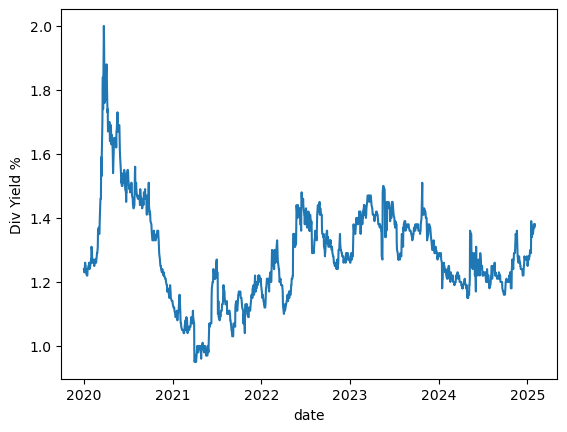

In [15]:
sns.lineplot(dividend, x = col_dict['date_col'], y = col_dict['div_yield_col'])

In [16]:
dividend[col_dict['div_yield_col']] = np.log(1 + (dividend[col_dict['div_yield_col']]/100))
dividend[col_dict['div_yield_col']].describe()

count    1267.000000
mean        0.012780
std         0.001495
min         0.009455
25%         0.011830
50%         0.012620
75%         0.013706
max         0.019803
Name: Div Yield %, dtype: float64

In [19]:
print(rff[col_dict['rff_col']].describe())
rff[col_dict['rff_col']] = np.log(1 + (rff[col_dict['rff_col']]/100))

count    110.000000
mean       5.595273
std        0.304103
min        4.880000
25%        5.290000
50%        5.740000
75%        5.760000
max        6.220000
Name: MIBOR, dtype: float64


In [20]:
print(rff[col_dict['rff_col']].describe())

count    110.000000
mean       0.054439
std        0.002883
min        0.047647
25%        0.051548
50%        0.055813
75%        0.056002
max        0.060342
Name: MIBOR, dtype: float64


c:\Users\Preet Lodaya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Preet Lodaya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='MIBOR', ylabel='Count'>

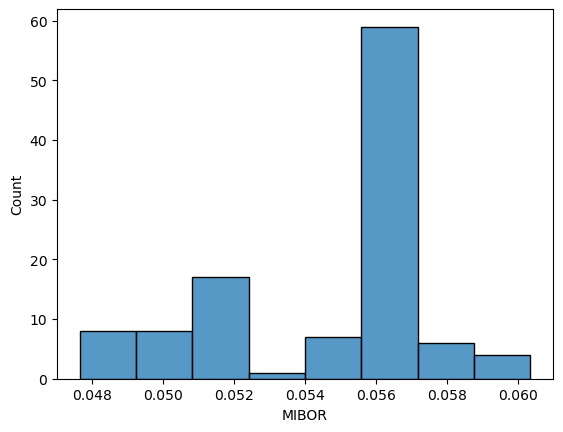

In [21]:
sns.histplot(rff[col_dict['rff_col']])

c:\Users\Preet Lodaya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Preet Lodaya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Div Yield %', ylabel='Count'>

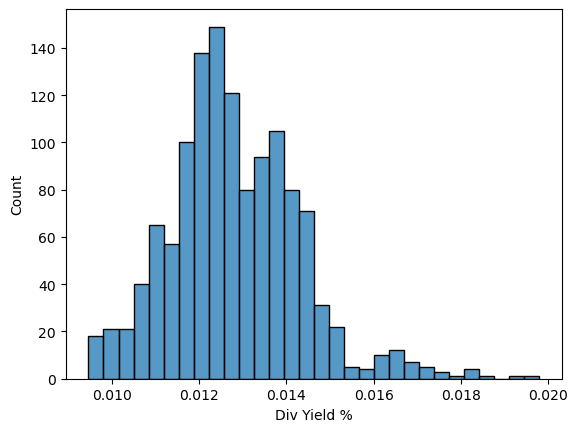

In [23]:
sns.histplot(dividend[col_dict['div_yield_col']])

In [21]:
data[col_dict['expiry_type_col']] = data.groupby(col_dict['time_col'])[col_dict['expiry_col']].rank(method='first')

In [32]:
data[['expiry_date','expiry_type']]

expiry_date  expiry_type
0      2020-01-30          1.0
8261   2020-02-27          2.0
15824  2020-02-27          1.0
23336  2020-03-26          3.0
23342  2020-03-26          2.0

In [48]:
counts = data.groupby(['datetime'],as_index=False)[col_dict['expiry_col']].nunique()
counts[col_dict['expiry_col']].value_counts()

expiry_date
3    359536
2     74246
1      3850
Name: count, dtype: int64

In [50]:
data[col_dict['expiry_type_col']].value_counts()

expiry_type
1.0    440258
2.0    436407
3.0    363642
4.0     13109
5.0      8019
6.0       292
Name: count, dtype: int64

In [51]:
data.loc[data[col_dict['oi_col']]>0].shape[0]/data.shape[0]

0.9763506685677646

In [46]:
data.loc[data[col_dict['time_col']] == '2021-10-29 09:16:00']

datetime stock_code exchange_code product_type expiry_date  \
455295 2021-10-29 09:16:00      NIFTY           NFO      Futures  2021-11-25   
468210 2021-10-29 09:16:00      NIFTY           NFO      Futures  2021-12-30   
483982 2021-10-29 09:16:00      NIFTY           NFO      Futures  2022-01-27   
483983 2021-10-29 09:16:00      NIFTY           NFO      Futures  2022-01-27   

         right  strike_price        open        high         low       close  \
455295  Others             0  17782.5000  17783.8008  17742.0508  17780.6992   
468210  Others             0  17856.4492  17856.5000  17811.2500  17850.7500   
483982  Others             0  17921.0500  17921.0500  17880.0500  17900.0000   
483983  Others             0  17926.3496  17926.3496  17880.0508  17900.0000   

        volume  open_interest  count  expiry_type  
455295  186050       10412450  14337          1.0  
468210    5650         743550   6468          2.0  
483982     900              0      2          3.0  
483983    1100         743550      3          4.0

In [44]:
data.loc[data[col_dict['expiry_type_col']]>3]['datetime']

483981   2021-10-29 09:15:00
483983   2021-10-29 09:16:00
483985   2021-10-29 09:17:00
483987   2021-10-29 09:18:00
483989   2021-10-29 09:19:00
                 ...        
849744   2023-02-22 15:27:00
849745   2023-02-22 15:28:00
849746   2023-02-22 15:28:00
849747   2023-02-22 15:29:00
849748   2023-02-22 15:29:00
Name: datetime, Length: 21420, dtype: datetime64[ns]

In [27]:
counts[counts[col_dict['expiry_col']]<3]['datetime'].dt.isocalendar().week.value_counts()

week
36    2567
6     2368
1     2355
27    2339
5     2269
45    2213
32    2113
37    2012
28    1993
19    1920
49    1899
9     1886
31    1836
7     1833
2     1831
3     1804
23    1802
10    1767
14    1735
44    1681
22    1675
24    1605
18    1585
34    1568
33    1519
40    1492
50    1457
20    1430
26    1428
46    1404
38    1399
35    1359
48    1284
17    1276
43    1231
41    1227
47    1217
8     1154
29    1113
42    1101
25    1045
51    1032
4     1005
30     973
15     962
21     912
16     909
13     789
11     678
39     671
52     633
12     593
53     312
Name: count, dtype: Int64

In [13]:
counts[counts[col_dict['expiry_col']]<3]

datetime  expiry_date
2      2020-01-01 09:17:00            2
6      2020-01-01 09:21:00            2
7      2020-01-01 09:22:00            2
9      2020-01-01 09:24:00            2
12     2020-01-01 09:27:00            2
...                    ...          ...
440142 2024-09-27 13:34:00            2
440143 2024-09-27 13:35:00            2
440171 2024-09-27 14:03:00            2
440191 2024-09-27 14:23:00            2
440195 2024-09-27 14:27:00            2

[78261 rows x 2 columns]

In [22]:
data[col_dict['date_col']] = pd.to_datetime(data[col_dict['time_col']].dt.date)

In [17]:
data.loc[data['date']==pd.to_datetime('2020-01-01')].groupby(col_dict['time_col'])[col_dict['expiry_col']].unique()

datetime
2020-01-01 09:15:00    [2020-01-30 00:00:00, 2020-02-27 00:00:00, 202...
2020-01-01 09:16:00    [2020-01-30 00:00:00, 2020-02-27 00:00:00, 202...
2020-01-01 09:17:00           [2020-01-30 00:00:00, 2020-02-27 00:00:00]
2020-01-01 09:18:00    [2020-01-30 00:00:00, 2020-02-27 00:00:00, 202...
2020-01-01 09:19:00    [2020-01-30 00:00:00, 2020-02-27 00:00:00, 202...
                                             ...                        
2020-01-01 15:26:00    [2020-01-30 00:00:00, 2020-02-27 00:00:00, 202...
2020-01-01 15:27:00    [2020-01-30 00:00:00, 2020-02-27 00:00:00, 202...
2020-01-01 15:28:00    [2020-01-30 00:00:00, 2020-02-27 00:00:00, 202...
2020-01-01 15:29:00           [2020-01-30 00:00:00, 2020-02-27 00:00:00]
2020-01-01 15:30:00                                [2020-01-30 00:00:00]
Name: expiry_date, Length: 376, dtype: object

In [54]:
data.loc[data[col_dict['oi_col']]==0][col_dict['date_col']].dt.weekday.value_counts()

date
0    6928
4    6196
1    5661
3    5529
2    5525
Name: count, dtype: int64

c:\Users\Preet Lodaya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Preet Lodaya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Preet Lodaya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='expiry_type', ylabel='volume'>

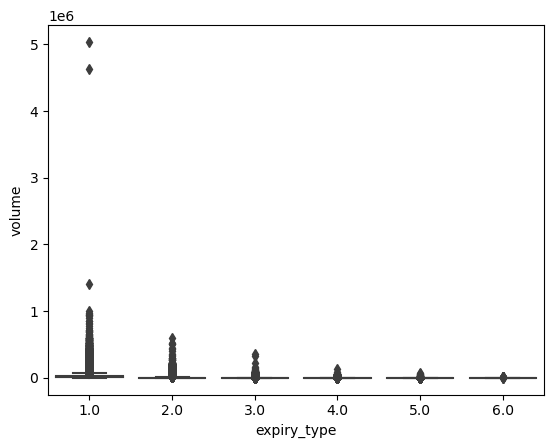

In [55]:
sns.boxplot(data, x = col_dict['expiry_type_col'], y = col_dict['volume_col'])

In [57]:
data.groupby(col_dict['expiry_type_col'])[col_dict['volume_col']].describe()

count          mean           std  min     25%      50%  \
expiry_type                                                               
1.0          440258.0  25488.838347  32746.914408  0.0  8450.0  15975.0   
2.0          436407.0   4515.839256  10017.236390  0.0   500.0   1350.0   
3.0          363642.0    679.735944   2207.096440  0.0    75.0    250.0   
4.0           13109.0    748.836677   3518.285095  0.0    50.0    200.0   
5.0            8019.0    432.915576   1733.976977  0.0    50.0    200.0   
6.0             292.0   1351.027397   1396.891113  0.0   450.0    900.0   

                 75%        max  
expiry_type                      
1.0          30825.0  5039700.0  
2.0           4150.0   599600.0  
3.0            650.0   353625.0  
4.0            450.0   133200.0  
5.0            450.0    70950.0  
6.0           1750.0    10250.0

In [15]:
dummy_data = pd.DataFrame({'a':[1,2,3,4,5],'b':[5,4,3,2,1],'c':[1,2,3,4,5]})
def exponential(x):
    return np.exp(x - 1) 
exponential(dummy_data)*2

a           b           c
0    2.000000  109.196300    2.000000
1    5.436564   40.171074    5.436564
2   14.778112   14.778112   14.778112
3   40.171074    5.436564   40.171074
4  109.196300    2.000000  109.196300

In [23]:
from utils import continuous_compounder, calcualte_returns
data_returns = data.groupby([col_dict['expiry_col'],col_dict['date_col']]).apply(lambda x: calcualte_returns(x, col_dict))
returns_cols = [col for col in data.columns if 'returns' in col]
# data[returns_cols] = data[returns_cols].apply(lambda x: continuous_compounder(x)*100)

In [24]:
near_month = data_returns.loc[(data_returns[col_dict['expiry_type_col']]==1)]
th95 = near_month[col_dict['volume_col']].quantile(0.95)
near_month['high_volume'] = 0
near_month.loc[near_month[col_dict['volume_col']]>th95,'high_volume'] = 1

# sns.scatterplot(near_month.loc[near_month[col_dict['volume_col']]>=th95], x = col_dict['time_col'], y = col_dict['close_price_col'],color='red')
# plt.show()

C:\Users\Preet Lodaya\AppData\Local\Temp\ipykernel_21888\1202316436.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  near_month['high_volume'] = 0


c:\Users\Preet Lodaya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Preet Lodaya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Preet Lodaya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Preet Lodaya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

<Axes: xlabel='datetime', ylabel='close'>

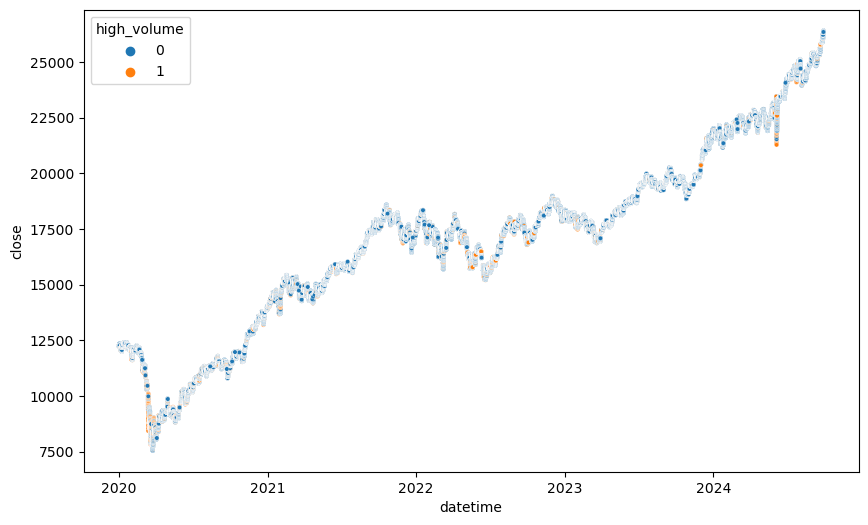

In [25]:
plt.figure(figsize=(10,6))
sns.scatterplot(near_month, x = col_dict['time_col'], y = col_dict['close_price_col'],hue='high_volume',s = 10)

c:\Users\Preet Lodaya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Preet Lodaya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Preet Lodaya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Preet Lodaya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

<Axes: xlabel='datetime', ylabel='returns'>

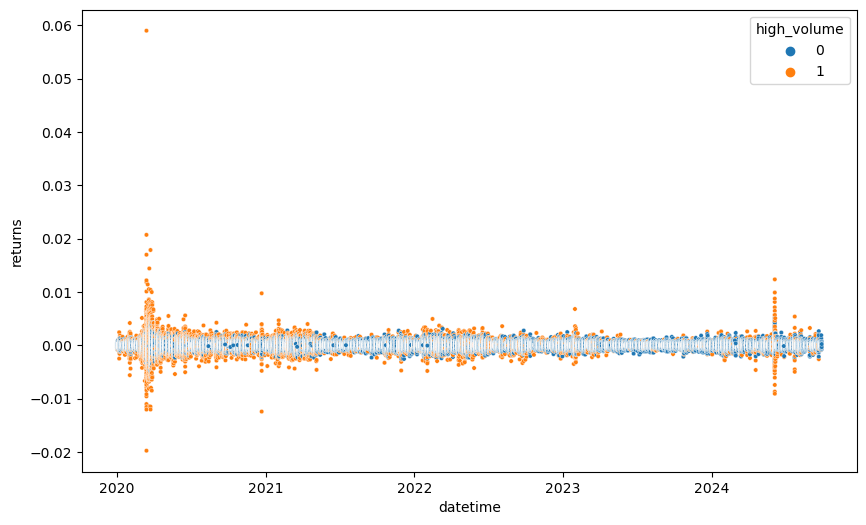

In [26]:
plt.figure(figsize=(10,6))
sns.scatterplot(near_month, x = col_dict['time_col'], y = 'returns',hue='high_volume',s = 10)

In [43]:
data[col_dict['expiry_type_col']].value_counts()

expiry_type
1.0    440258
2.0    436407
3.0    363642
4.0     13109
5.0      8019
6.0       292
Name: count, dtype: int64

In [ ]:
exp_check = data.drop(columns=['count',col_dict['expiry_type_col']]).drop_duplicates().groupby(col_dict['time_col']).agg(zero_oi = (col_dict['oi_col'],lambda x: (x==0).any()), num_expiries = (col_dict['expiry_col'],'count'))
# exp_check.loc[exp_check['zero_oi']==True]['num_expiries'].value_counts()

In [93]:
subset = exp_check.loc[exp_check['num_expiries']>3]
# subset['num_expiries'].sum()/data.drop(columns=['count',col_dict['expiry_type_col']]).drop_duplicates().shape[0]
subset['zero_oi'].sum()/subset.shape[0]

0.9937762564182355

In [59]:
exp_check.loc[exp_check['zero_oi']==True]['num_expiries'].value_counts()

num_expiries
5    7709
4    5065
3    4097
2     235
1       3
Name: count, dtype: int64

In [62]:
exp_check.loc[(exp_check['zero_oi']==False)&(exp_check['num_expiries']>3)]#.reset_index()['datetime'].dt.date.value_counts()

zero_oi  num_expiries
datetime                                  
2023-02-22 09:19:00    False             4
2023-02-22 09:20:00    False             5
2023-02-22 09:21:00    False             5
2023-02-22 09:22:00    False             6
2023-02-22 09:23:00    False             6
...                      ...           ...
2023-02-22 11:14:00    False             6
2023-02-22 11:15:00    False             6
2023-02-22 11:16:00    False             4
2023-02-22 11:17:00    False             4
2023-02-22 11:18:00    False             4

[80 rows x 2 columns]

In [65]:
data.loc[data[col_dict['time_col']]==pd.Timestamp('2023-02-22 09:22:00')].drop(columns=['count','expiry_type']).drop_duplicates()

datetime stock_code exchange_code product_type expiry_date  \
819075 2023-02-22 09:22:00      NIFTY           NFO      Futures  2023-02-23   
819076 2023-02-22 09:22:00      NIFTY           NFO      Futures  2023-02-23   
833297 2023-02-22 09:22:00      NIFTY           NFO      Futures  2023-03-29   
833298 2023-02-22 09:22:00      NIFTY           NFO      Futures  2023-03-29   
849095 2023-02-22 09:22:00      NIFTY           NFO      Futures  2023-04-27   
849096 2023-02-22 09:22:00      NIFTY           NFO      Futures  2023-04-27   

         right  strike_price      open      high       low     close  volume  \
819075  Others             0  17740.60  17745.90  17738.45  17742.65   22200   
819076  Others             0  17739.65  17745.90  17738.45  17741.00   25550   
833297  Others             0  17841.75  17850.00  17840.55  17846.00   32300   
833298  Others             0  17841.75  17848.00  17841.55  17845.00   32100   
849095  Others             0  17960.25  17964.00  17960.25  17961.10     800   
849096  Others             0  17960.50  17964.95  17959.40  17961.10    1250   

        open_interest       date  
819075        6958000 2023-02-22  
819076        6958000 2023-02-22  
833297        4556200 2023-02-22  
833298        4556200 2023-02-22  
849095         619800 2023-02-22  
849096         619800 2023-02-22

In [84]:
exp_check.loc[(exp_check['zero_oi']==True)&(exp_check['num_expiries']<=3)].reset_index()['datetime'].dt.date.value_counts().head(30)

datetime
2022-04-01    375
2022-04-04    375
2022-04-11    375
2022-04-08    375
2022-04-07    375
2022-04-06    375
2022-04-05    375
2021-12-01    125
2021-12-02    116
2021-12-10    111
2021-12-08    106
2021-12-09     96
2021-12-15     84
2021-11-29     83
2021-12-03     82
2021-12-16     81
2021-12-07     77
2021-12-22     75
2021-11-26     74
2021-12-06     73
2021-11-30     63
2021-12-23     56
2021-12-13     55
2021-12-24     50
2021-12-14     47
2021-12-28     31
2021-12-27     29
2021-12-21     29
2021-12-29     28
2021-12-17     27
Name: count, dtype: int64

In [87]:
data.loc[data['datetime']==pd.Timestamp('2021-12-10 10:20:00')]

datetime stock_code exchange_code product_type expiry_date  \
478408 2021-12-10 10:20:00      NIFTY           NFO      Futures  2021-12-30   
501711 2021-12-10 10:20:00      NIFTY           NFO      Futures  2022-01-27   
501712 2021-12-10 10:20:00      NIFTY           NFO      Futures  2022-01-27   

         right  strike_price        open        high         low       close  \
478408  Others             0  17503.0000  17505.0000  17495.0508  17497.1504   
501711  Others             0  17564.5508  17564.5508  17555.4004  17559.6504   
501712  Others             0  17564.5500  17564.5500  17555.4000  17559.6500   

        volume  open_interest  count  expiry_type       date  
478408   17950       11516900  16666          1.0 2021-12-10  
501711     800        1229550  17731          2.0 2021-12-10  
501712     750              0  17732          3.0 2021-12-10

In [29]:
near_month.groupby('high_volume')['returns'].describe()

count          mean       std       min       25%       50%  \
high_volume                                                                   
0            418147.0  8.413121e-07  0.000363 -0.006045 -0.000178  0.000000   
1             20932.0  7.864159e-06  0.001403 -0.019796 -0.000647  0.000013   

                  75%       max  
high_volume                      
0            0.000180  0.005568  
1            0.000632  0.058992

(array([3.88109e+05, 4.02390e+04, 7.80100e+03, 2.33300e+03, 8.50000e+02,
        4.25000e+02, 2.15000e+02, 1.03000e+02, 6.80000e+01, 3.70000e+01,
        2.50000e+01, 2.30000e+01, 6.00000e+00, 6.00000e+00, 3.00000e+00,
        1.00000e+00, 4.00000e+00, 1.00000e+00, 4.00000e+00, 2.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

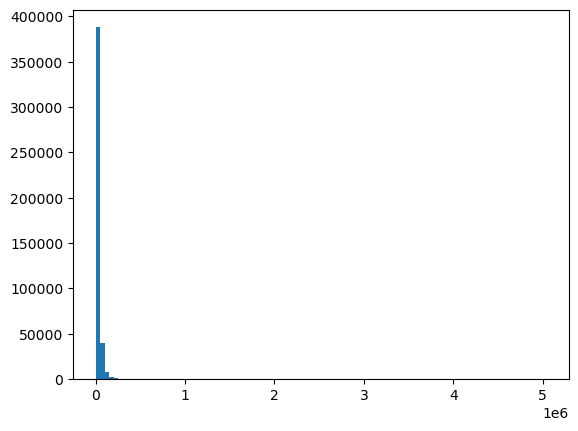

In [59]:
plt.hist(data.loc[data[col_dict['expiry_type_col']]==1][col_dict['volume_col']], bins = 100)

In [8]:
nifty = pd.read_csv('Data/Nifty_01Jan2020_29Jan2025.csv',parse_dates=['datetime'])

In [9]:
## Cleansing nifty data
nifty.drop(columns = 'count',inplace=True)
print(nifty.shape)
nifty.drop_duplicates(inplace=True)
print(nifty.shape)
nifty = nifty.groupby(col_dict['time_col'],as_index=False).first()
print(nifty.shape)

(897409, 13)
(528051, 13)
(526993, 13)


In [1]:
sns.lineplot(nifty, x = 'datetime', y = 'close')

NameError: name 'sns' is not defined

In [11]:
nifty.loc[nifty['datetime'].dt.year==2021]

datetime stock_code exchange_code  product_type  \
93418  2021-08-04 07:41:00      NIFTY           NSE           NaN   
93419  2021-08-04 07:42:00      NIFTY           NSE           NaN   
93420  2021-08-04 07:43:00      NIFTY           NSE           NaN   
93421  2021-08-04 07:44:00      NIFTY           NSE           NaN   
93422  2021-08-04 07:45:00      NIFTY           NSE           NaN   
...                    ...        ...           ...           ...   
144476 2021-12-31 15:57:00      NIFTY           NSE           NaN   
144477 2021-12-31 15:58:00      NIFTY           NSE           NaN   
144478 2021-12-31 15:59:00      NIFTY           NSE           NaN   
144479 2021-12-31 16:00:00      NIFTY           NSE           NaN   
144480 2021-12-31 16:01:00      NIFTY           NSE           NaN   

        expiry_date  right  strike_price      open      high       low  \
93418           NaN    NaN           NaN  16130.75  16130.75  16130.75   
93419           NaN    NaN           NaN  16130.75  16130.75  16130.75   
93420           NaN    NaN           NaN  16130.75  16130.75  16130.75   
93421           NaN    NaN           NaN  16130.75  16130.75  16130.75   
93422           NaN    NaN           NaN  16130.75  16130.75  16130.75   
...             ...    ...           ...       ...       ...       ...   
144476          NaN    NaN           NaN  17354.05  17354.05  17354.05   
144477          NaN    NaN           NaN  17354.05  17354.05  17354.05   
144478          NaN    NaN           NaN  17354.05  17354.05  17354.05   
144479          NaN    NaN           NaN  17354.05  17354.05  17354.05   
144480          NaN    NaN           NaN  17354.05  17354.05  17354.05   

           close  volume  open_interest  
93418   16130.75     NaN            NaN  
93419   16130.75     NaN            NaN  
93420   16130.75     NaN            NaN  
93421   16130.75     NaN            NaN  
93422   16130.75     NaN            NaN  
...          ...     ...            ...  
144476  17354.05     NaN            NaN  
144477  17354.05     NaN            NaN  
144478  17354.05     NaN            NaN  
144479  17354.05     NaN            NaN  
144480  17354.05     NaN            NaN  

[51063 rows x 13 columns]

In [3]:
data_prep = pd.read_csv('Preprocessed_Inputs/Nifty_Futures_01Jan2020_29Jan25.csv',parse_dates=['datetime','expiry_date', col_dict['date_col']])
data_prep.head(3)

datetime expiry_date stock_code exchange_code product_type  \
0 2020-01-01 09:15:00  2020-01-30      NIFTY           NFO      Futures   
1 2020-01-01 09:15:00  2020-02-27      NIFTY           NFO      Futures   
2 2020-01-01 09:15:00  2020-03-26      NIFTY           NFO      Futures   

    right  strike_price        open        high         low  ...  low_equity  \
0  Others             0  12253.9502  12266.7500  12252.7002  ...    12201.55   
1  Others             0  12302.2500  12309.8496  12297.0498  ...    12201.55   
2  Others             0  12309.0498  12348.5996  12309.0498  ...    12201.55   

   open_equity  volume_equity returns_equity log_returns_equity  \
0     12201.55            0.0        0.00109           0.001089   
1     12201.55            0.0        0.00109           0.001089   
2     12201.55            0.0        0.00109           0.001089   

   overnight_returns_equity  overnight_log_returns_equity  \
0                 -0.000049                     -0.000049   
1                 -0.000049                     -0.000049   
2                 -0.000049                     -0.000049   

  intraday_returns_equity  intraday_log_returns_equity  time_to_expiry  
0                0.001139                     0.001139        0.076712  
1                0.001139                     0.001139        0.153425  
2                0.001139                     0.001139        0.230137  

[3 rows x 39 columns]

In [4]:
from modelling import calculate_theoretical_futures_price
near_month_data = data_prep[data_prep[col_dict['expiry_type_col']] == 'near']
near_month_data = calculate_theoretical_futures_price(near_month_data,
                                                      [col_dict['open_price_col'], col_dict['close_price_col']], 
                                                      col_dict)

mid_month_data = data_prep[data_prep[col_dict['expiry_type_col']] == 'mid']
mid_month_data = calculate_theoretical_futures_price(mid_month_data,
                                                      [col_dict['open_price_col'], col_dict['close_price_col']], 
                                                      col_dict)
far_month_data = data_prep[data_prep[col_dict['expiry_type_col']] == 'far']
far_month_data = calculate_theoretical_futures_price(far_month_data,
                                                      [col_dict['open_price_col'], col_dict['close_price_col']], 
                                                      col_dict)

c:\Users\Preet Lodaya\Quant\modelling.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[[f"{col}_theoretical" for col in price_cols]] = data[price_cols].mul(np.exp((data[col_dict['rfr_col']] - data[col_dict['div_yield_col']])*data['time_to_expiry']),axis=0)
c:\Users\Preet Lodaya\Quant\modelling.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[[f"{col}_theoretical" for col in price_cols]] = data[price_cols].mul(np.exp((data[col_dict['rfr_col']] - data[col_dict['div_yield_col']])*data['time_to_

In [5]:

req_cols = [col_dict['time_col'], col_dict['open_price_col'], col_dict['close_price_col'], col_dict['high_price_col'], col_dict['low_price_col'], 
            col_dict['volume_col'], col_dict['oi_col'], col_dict['expiry_col'],
            f"{col_dict['open_price_col']}_theoretical", f"{col_dict['close_price_col']}_theoretical", 
            f"{col_dict['open_price_col']}_price_diff", f"{col_dict['close_price_col']}_price_diff"]
final_data1 = pd.merge(near_month_data, mid_month_data[req_cols], on=col_dict['time_col'], suffixes=('_near', '_mid'), how = 'left')
final_data = pd.merge(final_data1, far_month_data[req_cols].rename(columns = {c:f"{c}_far" for c in req_cols if c != col_dict['time_col']}), 
                      on=col_dict['time_col'], how = 'left')

In [6]:
(data_prep[f"{col_dict['expiry_col']}"] - data_prep[col_dict['date_col']]).dt.days

0          29
1          57
2          85
3          29
4          57
           ..
1238649    34
1238650    90
1238651    62
1238652    34
1238653    90
Length: 1238654, dtype: int64

In [23]:
(data_prep['time_to_expiry']*365).min()

-0.999999999999978

In [7]:
# final_data['days_to_expiry_near'] = (final_data[f"{col_dict['expiry_col']}_near"] - final_data[col_dict['date_col']]).dt.days
# final_data['days_to_expiry_mid'] = (final_data[f"{col_dict['expiry_col']}_mid"] - final_data[col_dict['date_col']]).dt.days
# final_data['days_to_expiry_far'] = (final_data[f"{col_dict['expiry_col']}_far"] - final_data[col_dict['date_col']]).dt.days
data_prep['days_to_expiry'] = (data_prep[f"{col_dict['expiry_col']}"] - data_prep[col_dict['date_col']]).dt.days

In [25]:
data_prep.columns

Index(['datetime', 'expiry_date', 'stock_code', 'exchange_code',
       'product_type', 'right', 'strike_price', 'open', 'high', 'low', 'close',
       'volume', 'open_interest', 'date', 'expiry_type', 'MIBOR', 'prev_MIBOR',
       'IndexName', 'P/E', 'P/B', 'Div Yield %', 'returns', 'log_returns',
       'overnight_returns', 'overnight_log_returns', 'intraday_returns',
       'intraday_log_returns', 'close_equity', 'high_equity', 'low_equity',
       'open_equity', 'volume_equity', 'returns_equity', 'log_returns_equity',
       'overnight_returns_equity', 'overnight_log_returns_equity',
       'intraday_returns_equity', 'intraday_log_returns_equity',
       'time_to_expiry', 'days_to_expiry'],
      dtype='object')

In [50]:
import scipy.stats as stats

def fit_line(group, col1, col2):
    group = group.dropna(subset = [col1,col2])
    if group.shape[0] > 0:
        slope, intercept, r_value, p_value, _ = stats.linregress(group[col1], group[col2])
    else:
        slope, intercept, r_value, p_value = [np.nan]*4
    return pd.Series({'slope':slope,'intercept':intercept,'r_value':r_value, 'p_value':p_value})
returns_over_toe = data_prep.groupby('days_to_expiry').apply(lambda g: fit_line(g, 'intraday_log_returns', 'intraday_log_returns_equity') )

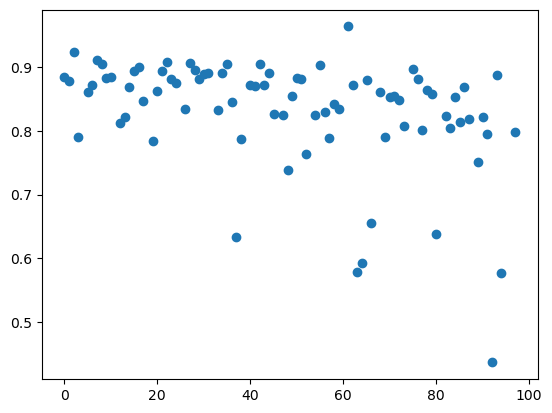

In [53]:
plt.scatter(x= returns_over_toe.index,y = returns_over_toe['slope'])

In [ ]:
stats.linregress(x, y,)

LinregressResult(slope=1.001, intercept=8.881784197001252e-16, rvalue=0.9999999999999999, pvalue=0.0, stderr=1.060038393099934e-09, intercept_stderr=6.405123552736782e-09)

In [37]:
data_prep.groupby('days_to_expiry')[col_dict['date_col']].count().value_counts().sort_index()

date
57       1
60       2
657      1
766      1
987      1
        ..
21020    1
21022    1
21082    1
21357    1
21369    1
Name: count, Length: 84, dtype: int64

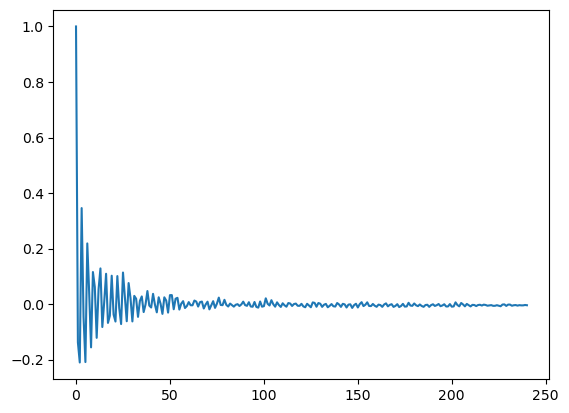

In [55]:
import pandas as pd
from statsmodels.tsa.stattools import acf

# Assuming final_data is your DataFrame and it contains the 'log_returns' column
# Check for NaN values and drop them if necessary
nlag = 240
data_count = final_data.groupby(col_dict['date_col'])[col_dict['time_col']].count()
acf_data = final_data.loc[final_data[col_dict['date_col']].isin(data_count.loc[data_count>nlag].index)]
acf_df = acf_data.dropna(subset=['log_returns']).groupby(col_dict['date_col']).apply(lambda g : pd.DataFrame({'Lag': range(nlag+1),
    'Autocorrelation': acf(g['log_returns'],nlags=nlag)}))
plt.plot(acf_df.groupby('Lag').mean())

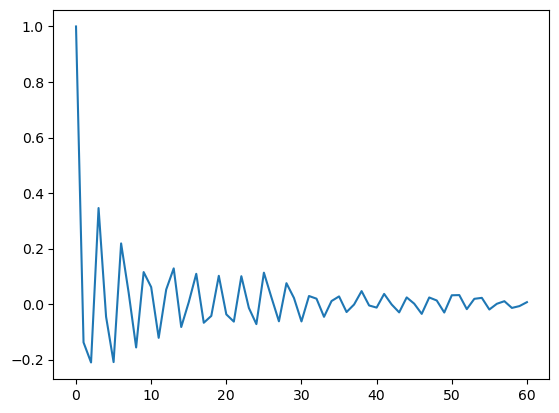

In [53]:
plt.plot(acf_df.groupby('Lag').mean())

In [24]:
from scipy.stats import pearsonr
def autocorrelation_any_frequency(data, column, col_dict, nlags = 60):
    '''Adjusts for the irregularity induced at EOD in stock market data
    with sub-daily frequency due to defined trading hours
    
    '''
    def calculate_correlation_and_pvalue(df, col1, col2):
        # Drop rows with NaN values in the specified columns
        df_clean = df.dropna(subset=[col1, col2])
        
        # Calculate the correlation and p-value
        correlation, p_value = pearsonr(df_clean[col1], df_clean[col2])
        return correlation, p_value
    autocorr_df = pd.DataFrame(columns=['lag','correlation','p_value'])
    for n in range(nlags + 1):
        data[f'{column}_lag_{n}'] = data.groupby([col_dict['date_col']])[column].shift(n)
        corr,p = calculate_correlation_and_pvalue(data, column, f'{column}_lag_{n}')
        autocorr_df = pd.concat([autocorr_df, 
                                 pd.DataFrame({'lag':[n], 'correlation':[corr],'p_value':[p]})],ignore_index=True)
    
    return autocorr_df
    

In [40]:
correlation_df = autocorrelation_any_frequency(final_data, 'log_returns',col_dict, nlags=375)

In [44]:
final_data[col_dict['time_col']].dt.time.value_counts().sort_index()

datetime
09:15:00    1173
09:16:00    1173
09:17:00    1174
09:18:00    1174
09:19:00    1174
            ... 
19:11:00       4
19:12:00       4
19:13:00       4
19:14:00       4
19:15:00       1
Name: count, Length: 512, dtype: int64

<Axes: xlabel='lag', ylabel='correlation'>

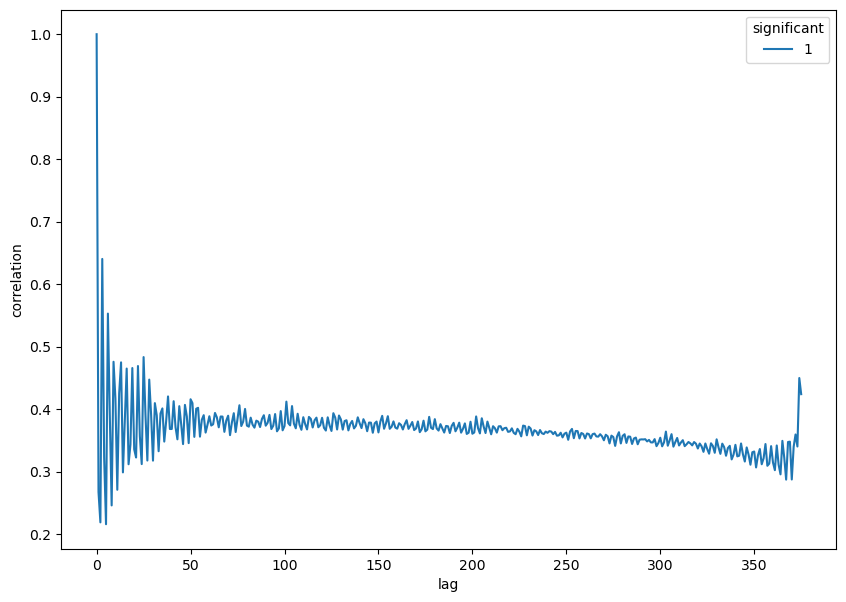

In [41]:
correlation_df['significant'] = 1
correlation_df.loc[correlation_df['p_value']>0.05, 'significant'] = 0
plt.figure(figsize=(10,7))
sns.lineplot(correlation_df, x = 'lag', y = 'correlation', hue = 'significant')

In [42]:
correlation_df.tail(100)

lag  correlation        p_value  significant
276  276     0.341274   0.000000e+00            1
277  277     0.356564   0.000000e+00            1
278  278     0.363176   0.000000e+00            1
279  279     0.345181   0.000000e+00            1
280  280     0.357370   0.000000e+00            1
281  281     0.359962   0.000000e+00            1
282  282     0.346043   0.000000e+00            1
283  283     0.356401   0.000000e+00            1
284  284     0.355960   0.000000e+00            1
285  285     0.344367   0.000000e+00            1
286  286     0.353185   0.000000e+00            1
287  287     0.354614   0.000000e+00            1
288  288     0.343904   0.000000e+00            1
289  289     0.351237   0.000000e+00            1
290  290     0.351740   0.000000e+00            1
291  291     0.351604   0.000000e+00            1
292  292     0.351994   0.000000e+00            1
293  293     0.348479   0.000000e+00            1
294  294     0.350875   0.000000e+00            1
295  295     0.346886   0.000000e+00            1
296  296     0.346862   0.000000e+00            1
297  297     0.352134   0.000000e+00            1
298  298     0.340862   0.000000e+00            1
299  299     0.345894   0.000000e+00            1
300  300     0.354381   0.000000e+00            1
301  301     0.340619   0.000000e+00            1
302  302     0.346942   0.000000e+00            1
303  303     0.364176   0.000000e+00            1
304  304     0.341577   0.000000e+00            1
305  305     0.350147   0.000000e+00            1
306  306     0.360088   0.000000e+00            1
307  307     0.340094   0.000000e+00            1
308  308     0.347371   0.000000e+00            1
309  309     0.353993   0.000000e+00            1
310  310     0.341985   0.000000e+00            1
311  311     0.346708   0.000000e+00            1
312  312     0.350459   0.000000e+00            1
313  313     0.340896   0.000000e+00            1
314  314     0.343874   0.000000e+00            1
315  315     0.347538   0.000000e+00            1
316  316     0.345383   0.000000e+00            1
317  317     0.342116   0.000000e+00            1
318  318     0.347489   0.000000e+00            1
319  319     0.344791   0.000000e+00            1
320  320     0.337124   0.000000e+00            1
321  321     0.345087   0.000000e+00            1
322  322     0.340621   0.000000e+00            1
323  323     0.331782   0.000000e+00            1
324  324     0.345163   0.000000e+00            1
325  325     0.336258   0.000000e+00            1
326  326     0.328818   0.000000e+00            1
327  327     0.345476   0.000000e+00            1
328  328     0.341134   0.000000e+00            1
329  329     0.330243   0.000000e+00            1
330  330     0.351830   0.000000e+00            1
331  331     0.339103   0.000000e+00            1
332  332     0.328537   0.000000e+00            1
333  333     0.344901   0.000000e+00            1
334  334     0.339326   0.000000e+00            1
335  335     0.325527   0.000000e+00            1
336  336     0.337869   0.000000e+00            1
337  337     0.341418   0.000000e+00            1
338  338     0.319685   0.000000e+00            1
339  339     0.327318   0.000000e+00            1
340  340     0.343039   0.000000e+00            1
341  341     0.324491   0.000000e+00            1
342  342     0.325591   0.000000e+00            1
343  343     0.345140   0.000000e+00            1
344  344     0.327851   0.000000e+00            1
345  345     0.316252   0.000000e+00            1
346  346     0.338878   0.000000e+00            1
347  347     0.327351   0.000000e+00            1
348  348     0.311203   0.000000e+00            1
349  349     0.331129   0.000000e+00            1
350  350     0.332331   0.000000e+00            1
351  351     0.306841   0.000000e+00            1
352  352     0.326172   0.000000e+00            1
353  353     0.336307   0.000000e+00            1
354  354     0.311903   0.000000e+00            1
355  